In [1]:
import os
import json
import numpy as np
from collections import defaultdict
import pprint
from nltk.translate.bleu_score import sentence_bleu

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import f1_score

import spacy
nlp = spacy.load("en_core_web_sm")

from collections import Counter

## Retrieve raw data

In [2]:
def get_traj_data(root):
    traj_path = os.path.join(root, 'pp', 'ann_0.json')
    with open(traj_path, 'r') as f:
        return json.load(f)

def get_subgoals(key, split, dat):
    root = dat[key]['root']
    traj_data = get_traj_data(root)
    gold_num_subgoals = len(traj_data['num']['action_high'])-1
    return gold_num_subgoals

In [3]:
def get_ref_instrs(root):
    ref_instrs = []
    for i in range(3):
        path = os.path.join(root, 'pp', 'ann_%d.json' % i)
        with open(path, 'r') as f:
            ex = json.load(f)
            ref_instrs.append([[word.strip() for word in subgoal if word.strip()!='.'] for subgoal in ex['ann']['instr']])
    return ref_instrs

### Lookup

In [4]:
# Map object type to variations
type_to_variations = {
    ' alarmclock ' : [' alarm clock ', ' clock ', ' alarm '],
    ' armchair ' : [' arm chair '],
    ' couch ' : ['sofa'],
    ' baseballbat ': [' baseball bat ', ' bat '],
    ' basketball ' : [' basket ball '],
    ' bathtub ' : [' bath tub ', ' bathtubbasin ', ' bathtub basin '],
    ' cabinet ': [' cupboard '],
    ' cellphone ': [' cell phone ', ' phone ', ' mobilephone ', ' mobile phone '],
    ' coffeemachine ': [' coffee machine ', ' coffeemaker ', ' coffee maker ', ' coffee maker machine '],
    ' countertop ': [' counter ', ' counter top ', ' island ', ' kitchen island '],
    ' creditcard ': [' credit card ', ' card '],
    ' cup ': [' mug '],
    ' curtains ': [' curtain '],
    ' table ': [' desk ', ' study desk ', ' studydesk ',' work desk ', ' workdesk '],
    ' desk lamp ': [' desklamp ', ' desk light ', ' desklight '],
    ' dishsponge ': [' dish sponge ', ' sponge '],
    ' floorlamp ': [' floor lamp ', ' lamp '],
    ' footstool ': [' foot stool ', ' stool '],
    ' fridge ': [' refrigerator '],
    ' garbagecan ': [' garbage can ', ' garbage bin ', ' trashcan ', ' trash can ', ' trash bin '],
    ' bottle ': [' glass bottle ', ' bottle ', ' glassbottle '],
    ' handtowel ': [' hand towel ', ' towel '],
    ' towelholder ': [' handtowel holder ', ' towel holder ', ' towelholder ', ' hand towel holder ', ' towelrack ', ' towel rack '],
    ' houseplant ': [' house plant ', ' plant '],
    ' knife ': [' butterknife ', ' butter knife '],
    ' laptop ': [' computer ', ' lap top '],
    ' laundryhamper ': [' laundry hamper ', ' hamper ', ' laundry basket ', ' laundrybasket '],
    ' laundryhamperlid ': [' laundry hamper lid ', ' laundry basket lid ', ' hamper lid ', ' basket lid '],
    ' lightswitch ': [' light switch '],
    ' mug ': [' cup '],
    ' papertowel ': [' paper towel '],
    ' papertowelroll ': [' papertowel roll ', ' paper towel roll '],
    ' peppershaker ': [' pepper shaker '],
    ' remotecontrol ': [' remote control ', ' remote '],
    ' saltshaker ': [' salt shaker '],
    ' brush ': [' scrub brush ', ' scrubbrush '],
    ' showerdoor ': [' shower door '],
    ' showerglass ': [' shower glass '],
    ' sinkbasin ': [' sink basin ', ' basin ', ' sink '],
    ' soapbar ': [' soap bar ', ' soap '],
    ' soapbottle ': [' soap bottle '],
    ' spraybottle ': [' spray bottle '],
    ' stoveburner ': [' stove burner ', ' stove ', ' burner '],
    ' stoveknob ': [' stove knob ', ' stove switch ', ' knob ', ' switch '],
    ' diningtable ': [' dining table '],
    ' coffeetable ': [' coffee table '],
    ' sidetable ': [' side table '],
    ' teddybear ': [' teddy bear ', ' bear '],
    ' tennisracket ': [' tennis racket ', ' racket '],
    ' tissuebox ': [' tissue box '],
    ' toiletpaper ': [' toilet paper '],
    ' toiletpaperhanger ': [' toilet paper hanger ', ' toiletpaper hanger '],
    ' toiletpaperroll ': [' toilet paper roll ', ' toiletpaper roll '],
    ' tvstand ': [' tv stand ', ' television stand ', ' televisionstand '],
    ' tv ': [' television '],
    ' wateringcan ': [' watering can '],
    ' winebottle ': [' wine bottle '],
}

# Map object variations to type
variation_to_type = {}
all_phrases_set = set()
for k,vals in type_to_variations.items():
    all_phrases_set.add(k.strip())
    for v in vals:
        variation_to_type[v] = k

# list of variations to scan each sentence
sorted_phrases = sorted(variation_to_type.keys(), key=lambda x: len(x), reverse=True)

## Compute BLEU

In [5]:
def tokensize_and_remove_fullstop(sent):
    words = sent.split(' ')
    if '.' in words:
        words.remove('.')
    return words

In [6]:
def print_subgoals(B_pred, V2_pred, anns):
    '''Debugging'''
    print('\nV2')
    for i in V2_pred:
        print (i, ' '.join(V2_pred[i]))
    print('\nB')
    for i in B_pred:
        print (i, ' '.join(B_pred[i]))
    print('\nAnn')
    for i in anns:
        print (i, [' '.join(ann) for ann in anns[i]])

In [7]:
def compute_human_bleu(anns):
    '''Compare how much human agree with each other'''
    refs = anns.copy()
    popped = []
    bleu_scores = []
    for i in range(len(refs)):
        compare_ann = refs.pop()
        bleu = sentence_bleu(refs+popped, compare_ann)
        bleu_scores.append(bleu)
        popped.append(compare_ann)
    return sum(bleu_scores)*1.0/len(bleu_scores)

## Compute F-1

In [8]:
def extract_nouns(tokens):
    # if these words are picked out as nouns because the annotation was poorly written, 
    # remove them from final set
    remove_nouns = {'left', 'right', 'top', 'down', 'front', 'back', 
                    'step', 'steps', 'remove', 'side', 'turn', 'middle', 
                    'face', 'head', 'end', 'walk', 'move'}
    
    sent = ' ' + ' '.join(tokens) + ' '

    # Map linguistic variations of an object back to one noun
    cleaned_sent = sent
    for phrase in sorted_phrases:
        # ToDo -- referring to global variation_to_type
        cleaned_sent = cleaned_sent.replace(phrase, variation_to_type[phrase])
    
    doc = nlp(cleaned_sent)
    
    # pick out the nouns
    nouns = [str(token) for token in doc if token.pos_ == 'NOUN' and not (str(token) in remove_nouns)]
    
    # if no nouns were picked, sometimes it's because the sentence was poorly written by annotators
    # try one last trick to check if there's overlap with env object set
    if len(nouns) == 0:
        resplit_tokens = cleaned_sent.strip().split(' ')
        nouns = (set(resplit_tokens) & all_phrases_set)
        
    return set(nouns)

In [9]:
def compute_precision(ann_noun_set, pred_noun_set):
    ct = 0
    matched = len(pred_noun_set) - len(pred_noun_set - ann_noun_set)
    return matched*1.0/len(pred_noun_set) if len(pred_noun_set) != 0 else 0

def compute_recall(ann_noun_set, pred_noun_set):
    ct = 0
    matched = len(ann_noun_set) - len(ann_noun_set - pred_noun_set)
    return matched*1.0/len(ann_noun_set) if len(ann_noun_set) != 0 else 0

In [10]:
def compute_f1(anns, main_pred):
    '''
    anns : list of 3 lists of tokens
    main_pred : list of tokens
    '''
    precisions = []
    recalls = []
    f1s = []
    predicted_nouns = extract_nouns(main_pred)
    for ann in anns:
        ann_nouns = extract_nouns(ann)
        precision = compute_precision(ann_nouns, predicted_nouns)
        
        recall = compute_recall(ann_nouns, predicted_nouns)
            
        precisions.append(precision)
        recalls.append(recall)
        
        if precision+recall != 0:
            f1 = 2*(precision*recall)/(precision+recall)
        else:
            f1 = 0
            
        f1s.append(f1)
    return sum(precisions)/len(precisions), sum(recalls)/len(recalls), sum(f1s)/len(f1s)

In [11]:
# test case
extract_nouns('put the sliced apple in the microwave '.split(' '))
extract_nouns('I pick up a tennisracket from the counter top '.split(' '))
extract_nouns('I pick up a tennis racket from the counter top '.split(' '))

{'countertop', 'tennisracket'}

In [12]:
# test case
compute_precision(set(['apple', 'lemon', 'kiwi']), set(['apple','banana']))
compute_precision(set(['apple','orange','banana']), set(['apple','banana']))

1.0

In [13]:
# test case
compute_recall(set(['apple', 'lemon', 'kiwi']), set(['apple','banana']))

0.3333333333333333

In [14]:
# test case
compute_f1([[ 'the', 'apple', 'is', 'on', 'the', 'countertop'],[ 'the', 'apple', 'is', 'in', 'the', 'fridge']], ['i', 'have', 'an', 'apple', 'and', 'some', 'bananas', 'in', 'the', 'fridge'])

(0.5, 0.75, 0.6000000000000001)

## Evaluation

In [185]:
def eval_results(split_str, split_keys, main_dat, base_dat, human_ann):

    subgoals = [
        'All',
        'PickupObject',
        'GotoLocation',
        'SliceObject',
        'PutObject',
        'HeatObject',
        'ToggleObject',
        'CoolObject',
        'CleanObject']
    
    score_keys = {subgoal:[] for subgoal in subgoals}
    BLEU_all = {subgoal:{'Main':[], 'Baseline':[], 'Annotation':[]} for subgoal in subgoals}
    BLEU_mean = {subgoal:{'Main':None, 'Baseline':None, 'Annotation':None} for subgoal in subgoals}
    
    RECALL_all = {subgoal:{'Main':[], 'Baseline':[], 'Annotation':[]} for subgoal in subgoals}
    PRECISION_all = {subgoal:{'Main':[], 'Baseline':[], 'Annotation':[]} for subgoal in subgoals}
    F1_all = {subgoal:{'Main':[], 'Baseline':[], 'Annotation':[]} for subgoal in subgoals}
    RECALL_mean = {subgoal:{'Main':None, 'Baseline':None} for subgoal in subgoals}
    PRECISION_mean = {subgoal:{'Main':None, 'Baseline':None} for subgoal in subgoals}
    F1_mean = {subgoal:{'Main':None, 'Baseline':None} for subgoal in subgoals}

    sent_lens = {subgoal:{'Main':[], 'Baseline':[], 'Annotation':[]} for subgoal in subgoals}
    word_counts = {subgoal:{'Main':defaultdict(int), 'Baseline':defaultdict(int), 'Annotation':defaultdict(int)} for subgoal in subgoals} 
    
    for i, key in enumerate(split_keys):
        gold_num_subgoals = get_subgoals(key, split_str, main_dat)
        gold_subgoal_names = main_dat[key]['action_high'][:-1]
        
        # get main explainer preds
        main_pred = main_dat[key]['p_lang_instr']
        main_pred = {subgoal_idx:tokensize_and_remove_fullstop(main_pred[str(subgoal_idx)]) for subgoal_idx in range(gold_num_subgoals)}
        # get baseline pred
        base_pred = base_dat[key]['p_lang_instr']
        base_pred = {subgoal_idx:tokensize_and_remove_fullstop(base_pred[str(subgoal_idx)]) for subgoal_idx in range(gold_num_subgoals)}
        # get human
        anns = {i:[] for i in range(gold_num_subgoals)}
        for j, ann in enumerate(human_ann[key[:-2]]):
            success = True
            for i in range(gold_num_subgoals):
                try:
                    anns[i].append(ann[i])
                except:
                    success = False
                    break
            assert success
            
        # check if numbers of subgoals match
        assert len(main_pred) == len(base_pred)== len(anns) == gold_num_subgoals
        
        for subgoal_i in range(gold_num_subgoals):
            # --------------------------------------------------------------------
            # Compute BLEU 
            subgoal_name = gold_subgoal_names[subgoal_i]
            score_keys[subgoal_name].append((key, subgoal_i)) 
            
            main_bleu = sentence_bleu(anns[subgoal_i], main_pred[subgoal_i])
            base_bleu = sentence_bleu(anns[subgoal_i], base_pred[subgoal_i])
            #ann_bleu = compute_human_bleu(anns[subgoal_i])

            BLEU_all[subgoal_name]['Main'].append(main_bleu)
            BLEU_all[subgoal_name]['Baseline'].append(base_bleu)
            #BLEU_all[subgoal_name]['Annotation'].append(ann_bleu)     

            BLEU_all['All']['Main'].append(main_bleu)
            BLEU_all['All']['Baseline'].append(base_bleu)
            #BLEU_all['All']['Annotation'].append(ann_bleu)
            
            # --------------------------------------------------------------------
            sent_lens[subgoal_name]['Main'].append(len(main_pred[subgoal_i]))
            sent_lens[subgoal_name]['Baseline'].append(len(base_pred[subgoal_i]))
            sent_lens[subgoal_name]['Annotation'].extend([len(a) for a in anns[subgoal_i]])
            
            for w in main_pred[subgoal_i]:
                word_counts[subgoal_name]['Main'][w] += 1

            for w in base_pred[subgoal_i]:
                word_counts[subgoal_name]['Baseline'][w] += 1
            
            for ann in anns[subgoal_i]:
                for w in ann:
                    word_counts[subgoal_name]['Annotation'][w] += 1
            # --------------------------------------------------------------------
            # compute F-1
            main_precision, main_recall, main_f1 = compute_f1(anns[subgoal_i], main_pred[subgoal_i])            
            base_precision, base_recall, base_f1 = compute_f1(anns[subgoal_i], base_pred[subgoal_i])      
        
            RECALL_all[subgoal_name]['Main'].append(main_recall)
            PRECISION_all[subgoal_name]['Main'].append(main_precision) 
            F1_all[subgoal_name]['Main'].append(main_f1)

            RECALL_all[subgoal_name]['Baseline'].append(base_recall)
            PRECISION_all[subgoal_name]['Baseline'].append(base_precision) 
            F1_all[subgoal_name]['Baseline'].append(base_f1)

            RECALL_all['All']['Main'].append(main_recall)
            PRECISION_all['All']['Main'].append(main_precision) 
            F1_all['All']['Main'].append(main_f1)
            
            RECALL_all['All']['Baseline'].append(base_recall)
            PRECISION_all['All']['Baseline'].append(base_precision) 
            F1_all['All']['Baseline'].append(base_f1)
            
        # --------------------------------------------------------------------
        
    for subgoal_name in subgoals:
        for mod in ['Main', 'Baseline']:
            BLEU_mean[subgoal_name][mod] = sum(BLEU_all[subgoal_name][mod])/len(BLEU_all[subgoal_name][mod])
            RECALL_mean[subgoal_name][mod] = sum(RECALL_all[subgoal_name][mod])/len(RECALL_all[subgoal_name][mod])
            PRECISION_mean[subgoal_name][mod] = sum(PRECISION_all[subgoal_name][mod])/len(PRECISION_all[subgoal_name][mod])
            F1_mean[subgoal_name][mod] = sum(F1_all[subgoal_name][mod])/len(F1_all[subgoal_name][mod])
                
    return (BLEU_all, RECALL_all, PRECISION_all, F1_all, sent_lens, word_counts), score_keys, BLEU_mean, RECALL_mean, PRECISION_mean, F1_mean

## Main

### Count of Subgoals

In [16]:
split_p = '/root/data_alfred/splits/may17.json'
with open(split_p, 'r') as f:
    train_split = json.load(f)['train']

data_dir = '/root/data_alfred/json_feat_2.1.0'

actions = []
for task_item in train_split:
    task = task_item['task']
    assert os.path.exists(data_dir)
    with open(os.path.join(data_dir, task, 'pp', 'ann_0.json'), 'r') as f:
        traj = json.load(f)
    for subgoal_i in range(len(traj['plan']['high_pddl'])):
        actions.append(traj['plan']['high_pddl'][subgoal_i]['discrete_action']['action'])
        
Counter(actions).most_common()

[('GotoLocation', 67022),
 ('PickupObject', 30459),
 ('PutObject', 28108),
 ('NoOp', 20806),
 ('SliceObject', 2973),
 ('CoolObject', 2908),
 ('HeatObject', 2875),
 ('CleanObject', 2824),
 ('ToggleObject', 2239)]

In [65]:
## split_p = '/root/data_alfred/splits/may17.json'
with open(split_p, 'r') as f:
    train_split = json.load(f)['valid_seen']

data_dir = '/root/data_alfred/json_feat_2.1.0'

actions = []
for task_item in train_split:
    task = task_item['task']
    assert os.path.exists(data_dir)
    with open(os.path.join(data_dir, task, 'pp', 'ann_0.json'), 'r') as f:
        traj = json.load(f)
    for subgoal_i in range(len(traj['plan']['high_pddl'])):
        actions.append(traj['plan']['high_pddl'][subgoal_i]['discrete_action']['action'])
        
Counter(actions).most_common()

[('GotoLocation', 2645),
 ('PickupObject', 1199),
 ('PutObject', 1091),
 ('NoOp', 814),
 ('SliceObject', 148),
 ('CoolObject', 132),
 ('CleanObject', 112),
 ('HeatObject', 104),
 ('ToggleObject', 94)]

In [19]:
split_p = '/root/data_alfred/splits/may17.json'
with open(split_p, 'r') as f:
    train_split = json.load(f)['valid_unseen']

data_dir = '/root/data_alfred/json_feat_2.1.0'

actions = []
for task_item in train_split:
    task = task_item['task']
    assert os.path.exists(data_dir)
    with open(os.path.join(data_dir, task, 'pp', 'ann_0.json'), 'r') as f:
        traj = json.load(f)
    for subgoal_i in range(len(traj['plan']['high_pddl'])):
        actions.append(traj['plan']['high_pddl'][subgoal_i]['discrete_action']['action'])
        
Counter(actions).most_common()

[('GotoLocation', 2445),
 ('PickupObject', 1113),
 ('PutObject', 937),
 ('NoOp', 818),
 ('ToggleObject', 170),
 ('HeatObject', 136),
 ('CleanObject', 113),
 ('SliceObject', 111),
 ('CoolObject', 109)]

### Eval Data

In [20]:
# Set Path
V2_dout = '/root/data/home/hoyeung/blob_alfred_data/exp_all/model:seq2seq_per_subgoal,name:v2_epoch_40_obj_instance_enc_max_pool_dec_aux_loss_weighted_bce_1to2'
B_dout = '/root/data/home/hoyeung/blob_alfred_data/exp_all/model:seq2seq_per_subgoal,name:v2_epoch_50_baseline'

In [21]:
# Set keys
path = os.path.join(V2_dout, 'valid_seen_argmax.debug_epoch_32.preds.json')
with open(path, 'r') as f:
    valid_seen_keys = list(json.load(f).keys())

path = os.path.join(V2_dout, 'valid_unseen_argmax.debug_epoch_32.preds.json')
with open(path, 'r') as f:
    valid_unseen_keys = list(json.load(f).keys())
    
path = os.path.join(V2_dout, 'train_sanity_argmax.debug_epoch_32.preds.json')
with open(path, 'r') as f:
    train_sanity_keys = list(json.load(f).keys())

In [22]:
# Read Predicted Data
path = os.path.join(V2_dout, 'valid_seen_argmax.debug_epoch_32.preds.json')
with open(path, 'r') as f:
    v2_valid_seen = json.load(f)

path = os.path.join(V2_dout, 'valid_unseen_argmax.debug_epoch_32.preds.json')
with open(path, 'r') as f:
    v2_valid_unseen = json.load(f)
    
path = os.path.join(V2_dout, 'train_sanity_argmax.debug_epoch_32.preds.json')
with open(path, 'r') as f:
    v2_train_sanity = json.load(f)

path = os.path.join(B_dout, 'valid_seen.debug_epoch_29.preds.json')
with open(path, 'r') as f:
    B_valid_seen = json.load(f)

path = os.path.join(B_dout, 'valid_unseen.debug_epoch_29.preds.json')
with open(path, 'r') as f:
    B_valid_unseen = json.load(f)
    
path = os.path.join(B_dout, 'train_sanity.debug_epoch_29.preds.json')
with open(path, 'r') as f:
    B_train_sanity = json.load(f)

In [23]:
# Read Human Annotations
human_anno_valid_seen = {}
human_anno_valid_unseen = {}
human_anno_train_sanity = {}

keys = set()
for key, dat in v2_valid_seen.items():
    root = dat['root']
    key = '_'.join(key.split('_')[:-1])
    if key not in keys:
        ref_instrs = get_ref_instrs(root)
        human_anno_valid_seen[key] = ref_instrs
        keys.add(key)
    
keys = set()
for key, dat in v2_valid_unseen.items():
    root = dat['root']
    key = '_'.join(key.split('_')[:-1])
    if key not in keys:
        ref_instrs = get_ref_instrs(root)
        human_anno_valid_unseen[key] = ref_instrs
        keys.add(key)
    
keys = set()
for key, dat in v2_train_sanity.items():
    root = dat['root']
    key = '_'.join(key.split('_')[:-1])
    if key not in keys:
        ref_instrs = get_ref_instrs(root)
        human_anno_train_sanity[key] = ref_instrs
        keys.add(key)

### Run Eval

In [24]:
All_valid_seen,   score_keys_valid_seen,   BLEU_valid_seen_mean,   RECALL_valid_seen,   PRECISION_mean_valid_seen,   F1_mean_valid_seen   = eval_results('valid_seen', valid_seen_keys, v2_valid_seen, B_valid_seen, human_anno_valid_seen)
All_valid_unseen, score_keys_valid_unseen, BLEU_valid_unseen_mean, RECALL_valid_unseen, PRECISION_mean_valid_unseen, F1_mean_valid_unseen = eval_results('valid_unseen', valid_unseen_keys, v2_valid_unseen, B_valid_unseen, human_anno_valid_unseen)
All_train_sanity, score_keys_train_sanity, BLEU_train_sanity_mean, RECALL_train_sanity, PRECISION_mean_train_sanity, F1_mean_train_sanity = eval_results('train_sanity', train_sanity_keys, v2_train_sanity, B_train_sanity, human_anno_train_sanity)

/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-g

In [186]:
d_All_valid_seen,   d_score_keys_valid_seen,   d_BLEU_valid_seen_mean,   d_RECALL_valid_seen,   d_PRECISION_mean_valid_seen,   d_F1_mean_valid_seen   = eval_results('valid_seen', valid_seen_keys, v2_valid_seen, B_valid_seen, human_anno_valid_seen)
d_All_valid_unseen, d_score_keys_valid_unseen, d_BLEU_valid_unseen_mean, d_RECALL_valid_unseen, d_PRECISION_mean_valid_unseen, d_F1_mean_valid_unseen = eval_results('valid_unseen', valid_unseen_keys, v2_valid_unseen, B_valid_unseen, human_anno_valid_unseen)
#All_train_sanity, score_keys_train_sanity, BLEU_train_sanity_mean, RECALL_train_sanity, PRECISION_mean_train_sanity, F1_mean_train_sanity = eval_results('train_sanity', train_sanity_keys, v2_train_sanity, B_train_sanity, human_anno_train_sanity)

### Linguistic Variation

In [280]:
from spacy.lang.en.stop_words import STOP_WORDS

In [288]:
cats = ('GotoLocation', 'SliceObject', 'PickupObject', 'PutObject', 'ToggleObject', 'CleanObject', 'HeatObject', 'CoolObject')

In [312]:
def make_normalized_dict(word_counts_dict):
    tot = sum(word_counts_dict.values())
    normalized_dict = {k:word_counts_dict[k]*1.0/tot for k in word_counts_dict.keys()}
    return normalized_dict
    
def print_ratio(word_counts_dict):
    normalized_dict = make_normalized_dict(word_counts_dict)
    return sorted(normalized_dict.items(), key=lambda x:x[1], reverse=True)

In [290]:
def plot_bars(V2_vals, B_vals, title, score_name, cat_names):
    plt.figure(figsize=(8, 6))
    
    N = len(cats)
    ind = np.arange(N)
    width = 0.35
    plt.ylim([0.0,1.0])
    
    # vertical lines
    plt.axvline(x=0.68, color='k', linestyle='dashed', linewidth=0.5 )
    plt.axvline(x=1.68, color='k', linestyle='dashed', linewidth=0.5 )
    plt.axvline(x=5.68, color='k', linestyle='dashed', linewidth=0.5 )
    plt.axvline(x=6.68, color='k', linestyle='dashed', linewidth=0.5 )
    
    # Main data
    plt.bar(ind, V2_vals, width, label='Explainer (with State-Tracking)', color='k')
    for index, value in enumerate(V2_vals): plt.text(index-0.2, value+0.01, str(round(value,2)))
    plt.bar(ind + width, B_vals, width, label='Baseline (without State-Tracking)', color='w', edgecolor='k')
    for index, value in enumerate(B_vals): plt.text(index+0.2, value+0.01, str(round(value,2)))
    
    plt.ylabel(score_name)
    plt.title(title)
    plt.xticks(ind + width / 2, cat_names, rotation=45)
    plt.legend(loc='upper left')
    plt.show()

In [349]:
Main_valid_seen_word_counts = defaultdict(int)

for subgoal in cats:
    word_dict = d_All_valid_seen[5][subgoal]['Main']
    for k,v in word_dict.items():
        if k not in STOP_WORDS and k != ',':
            Main_valid_seen_word_counts[k] += v
        
Counter(Main_valid_seen_word_counts).most_common()

[('turn', 1104),
 ('walk', 985),
 ('left', 420),
 ('right', 384),
 ('pick', 358),
 ('counter', 312),
 ('sink', 290),
 ('table', 282),
 ('fridge', 176),
 ('open', 140),
 ('wall', 131),
 ('door', 129),
 ('microwave', 124),
 ('knife', 120),
 ('room', 108),
 ('end', 105),
 ('tomato', 93),
 ('toilet', 86),
 ('place', 84),
 ('stove', 76),
 ('apple', 76),
 ('inside', 69),
 ('desk', 66),
 ('slice', 66),
 ('face', 57),
 ('shut', 52),
 ('soap', 49),
 ('coffee', 45),
 ('close', 44),
 ('plate', 42),
 ('lamp', 41),
 ('cabinet', 41),
 ('tv', 40),
 ('stand', 40),
 ('lettuce', 37),
 ('.', 37),
 ('potato', 36),
 ('couch', 35),
 ('bed', 35),
 ('pan', 35),
 ('bottle', 35),
 ('mug', 35),
 ('shelf', 34),
 ('dresser', 33),
 ('trash', 32),
 ('spoon', 32),
 ('chair', 29),
 ('black', 27),
 ('water', 27),
 ('tub', 26),
 ('spray', 26),
 ('drawer', 26),
 ('white', 24),
 ('bread', 24),
 ('bowl', 24),
 ('box', 23),
 ('remote', 22),
 ('corner', 21),
 ('small', 20),
 ('heat', 20),
 ('cup', 19),
 ('bar', 17),
 ('maker

In [350]:
Baseline_valid_seen_word_counts = defaultdict(int)

for subgoal in cats:
    word_dict = d_All_valid_seen[5][subgoal]['Baseline']
    for k,v in word_dict.items():
        if k not in STOP_WORDS and k != ',':
            Baseline_valid_seen_word_counts[k] += v
        
Counter(Baseline_valid_seen_word_counts).most_common()

[('turn', 1066),
 ('walk', 772),
 ('left', 514),
 ('right', 461),
 ('pick', 352),
 ('counter', 291),
 ('table', 291),
 ('sink', 288),
 ('fridge', 191),
 ('place', 130),
 ('microwave', 129),
 ('knife', 111),
 ('open', 100),
 ('face', 97),
 ('wall', 88),
 ('toilet', 87),
 ('tomato', 87),
 ('slice', 87),
 ('forward', 77),
 ('stove', 73),
 ('door', 73),
 ('room', 68),
 ('white', 64),
 ('apple', 64),
 ('desk', 62),
 ('close', 61),
 ('stand', 58),
 ('end', 55),
 ('soap', 53),
 ('coffee', 51),
 ('lettuce', 48),
 ('inside', 48),
 ('lamp', 46),
 ('potato', 45),
 ('cabinet', 44),
 ('shelf', 43),
 ('plate', 40),
 ('couch', 38),
 ('night', 37),
 ('pan', 37),
 ('bed', 34),
 ('bread', 33),
 ('dresser', 32),
 ('bowl', 31),
 ('bottle', 31),
 ('trash', 30),
 ('tv', 28),
 ('corner', 28),
 ('drawer', 28),
 ('chair', 27),
 ('egg', 27),
 ('mug', 27),
 ('water', 27),
 ('box', 26),
 ('tub', 24),
 ('black', 23),
 ('spoon', 22),
 ('heat', 22),
 ('remote', 21),
 ('bin', 20),
 ('cut', 20),
 ('spray', 20),
 ('cup

In [351]:
Annotation_valid_seen_word_counts = defaultdict(int)

for subgoal in cats:
    word_dict = d_All_valid_seen[5][subgoal]['Annotation']
    for k,v in word_dict.items():
        if k not in STOP_WORDS and k != ',':
            Annotation_valid_seen_word_counts[k] += v
        
Counter(Annotation_valid_seen_word_counts).most_common()

[('turn', 2389),
 ('left', 1518),
 ('right', 1437),
 ('walk', 1050),
 ('pick', 913),
 ('table', 881),
 ('sink', 877),
 ('counter', 762),
 ('face', 515),
 ('place', 487),
 ('fridge', 437),
 ('knife', 415),
 ('microwave', 377),
 ('tomato', 341),
 ('forward', 302),
 ('slice', 299),
 ('open', 267),
 ('toilet', 255),
 ('apple', 246),
 ('room', 236),
 ('stove', 229),
 ('door', 225),
 ('close', 206),
 ('refrigerator', 192),
 ('inside', 175),
 ('coffee', 168),
 ('desk', 168),
 ('soap', 153),
 ('plate', 152),
 ('kitchen', 151),
 ('cabinet', 151),
 ('white', 150),
 ('lamp', 144),
 ('end', 143),
 ('bottle', 140),
 ('shelf', 137),
 ('lettuce', 136),
 ('pan', 133),
 ('stand', 132),
 ('wall', 131),
 ('potato', 128),
 ('head', 128),
 ('black', 124),
 ('step', 108),
 ('drawer', 108),
 ('bread', 106),
 ('grab', 104),
 ('bed', 100),
 ('mug', 99),
 ('cup', 98),
 ('corner', 96),
 ('couch', 95),
 ('box', 91),
 ('spoon', 90),
 ('remote', 87),
 ('bin', 85),
 ('trash', 83),
 ('spray', 79),
 ('dresser', 77),
 

In [294]:
print_ratio(Main_valid_seen_word_counts)

[('turn', 0.14076246334310852),
 ('walk', 0.12558969781971185),
 ('left', 0.053550937141399975),
 ('right', 0.048960856814994264),
 ('pick', 0.04564579880147902),
 ('counter', 0.03978069616218284),
 (',', 0.03735815376769094),
 ('sink', 0.036975647073823795),
 ('table', 0.035955629223511414),
 ('fridge', 0.02244039270687237),
 ('open', 0.01785031238046666),
 ('wall', 0.01670279229886523),
 ('door', 0.016447787836287135),
 ('microwave', 0.015810276679841896),
 ('knife', 0.015300267754685707),
 ('room', 0.013770240979217136),
 ('end', 0.013387734285349994),
 ('tomato', 0.011857707509881422),
 ('toilet', 0.01096519189085809),
 ('place', 0.010710187428279994),
 ('stove', 0.009690169577967615),
 ('apple', 0.009690169577967615),
 ('inside', 0.008797653958944282),
 ('desk', 0.008415147265077139),
 ('slice', 0.008415147265077139),
 ('face', 0.007267627183475711),
 ('shut', 0.006630116027030473),
 ('soap', 0.006247609333163331),
 ('coffee', 0.00573760040800714),
 ('close', 0.005610098176718092)

In [295]:
print_ratio(Baseline_valid_seen_word_counts)

[('turn', 0.12877506644116937),
 ('walk', 0.09325924136264799),
 ('left', 0.06209229282435371),
 (',', 0.05641459289683499),
 ('right', 0.055689780140130464),
 ('pick', 0.04252234839333172),
 ('counter', 0.03515341870016912),
 ('table', 0.03515341870016912),
 ('sink', 0.03479101232181686),
 ('fridge', 0.023073206088427157),
 ('place', 0.015704276395264557),
 ('microwave', 0.015583474269147137),
 ('knife', 0.013409035999033583),
 ('open', 0.012080212611741966),
 ('face', 0.011717806233389708),
 ('wall', 0.01063058709833293),
 ('toilet', 0.01050978497221551),
 ('tomato', 0.01050978497221551),
 ('slice', 0.01050978497221551),
 ('forward', 0.009301763711041314),
 ('stove', 0.008818555206571635),
 ('door', 0.008818555206571635),
 ('room', 0.008214544575984537),
 ('white', 0.007731336071514858),
 ('apple', 0.007731336071514858),
 ('desk', 0.007489731819280019),
 ('close', 0.0073689296931626),
 ('stand', 0.007006523314810341),
 ('end', 0.0066441169364580815),
 ('soap', 0.006402512684223242),


In [296]:
print_ratio(Annotation_valid_seen_word_counts)

[('turn', 0.09159924849507305),
 (',', 0.05835665810360032),
 ('left', 0.05820328975115985),
 ('right', 0.05509758061424025),
 ('walk', 0.040259192515624403),
 ('pick', 0.03500632644453817),
 ('table', 0.03377937962501438),
 ('sink', 0.033626011272573905),
 ('counter', 0.02921667113991028),
 ('face', 0.019746175376711014),
 ('place', 0.0186725969096277),
 ('fridge', 0.016755492504121776),
 ('knife', 0.015911966565699168),
 ('microwave', 0.014454967217514665),
 ('tomato', 0.013074652045550401),
 ('forward', 0.01157931060925578),
 ('slice', 0.011464284344925425),
 ('open', 0.010237337525401633),
 ('toilet', 0.009777232468080212),
 ('apple', 0.009432153675089145),
 ('room', 0.00904873279398796),
 ('stove', 0.008780338177217132),
 ('door', 0.008626969824776657),
 ('close', 0.007898470150684407),
 ('refrigerator', 0.007361680917142748),
 ('inside', 0.006709865419270733),
 ('coffee', 0.0064414708024999046),
 ('desk', 0.0064414708024999046),
 ('soap', 0.005866339480848127),
 ('plate', 0.00582

In [352]:
Main_valid_unseen_word_counts = defaultdict(int)

for subgoal in cats:
    word_dict = d_All_valid_unseen[5][subgoal]['Main']
    for k,v in word_dict.items():
        if k not in STOP_WORDS and k != ',':
            Main_valid_unseen_word_counts[k] += v
        
Counter(Main_valid_unseen_word_counts).most_common()

[('turn', 1355),
 ('walk', 1186),
 ('left', 572),
 ('right', 538),
 ('counter', 461),
 ('wall', 367),
 ('pick', 336),
 ('sink', 296),
 ('stove', 153),
 ('open', 134),
 ('door', 128),
 ('desk', 125),
 ('fridge', 118),
 ('knife', 105),
 ('cabinet', 92),
 ('microwave', 91),
 ('lamp', 81),
 ('room', 77),
 ('end', 72),
 ('toilet', 71),
 ('apple', 68),
 ('place', 68),
 ('slice', 67),
 ('trash', 62),
 ('mug', 62),
 ('inside', 58),
 ('face', 54),
 ('soap', 54),
 ('water', 54),
 ('tomato', 52),
 ('lettuce', 51),
 ('bread', 48),
 ('shelf', 47),
 ('chair', 46),
 ('shut', 45),
 ('pan', 43),
 ('close', 42),
 ('egg', 39),
 ('couch', 38),
 ('.', 37),
 ('cup', 34),
 ('potato', 31),
 ('bowl', 30),
 ('salt', 30),
 ('shaker', 30),
 ('heat', 30),
 ('dresser', 28),
 ('black', 26),
 ('coffee', 26),
 ('maker', 26),
 ('bed', 24),
 ('remove', 23),
 ('plate', 22),
 ('spoon', 21),
 ('pencil', 21),
 ('keys', 21),
 ('drawer', 20),
 ('box', 19),
 ('corner', 18),
 ('bar', 18),
 ('fork', 18),
 ('floor', 17),
 ('cd', 

In [353]:
Baseline_valid_unseen_word_counts = defaultdict(int)

for subgoal in cats:
    word_dict = d_All_valid_unseen[5][subgoal]['Baseline']
    for k,v in word_dict.items():
        if k not in STOP_WORDS and k != ',':
            Baseline_valid_unseen_word_counts[k] += v
        
Counter(Baseline_valid_unseen_word_counts).most_common()

[('turn', 1202),
 ('walk', 886),
 ('left', 596),
 ('right', 581),
 ('counter', 466),
 ('pick', 324),
 ('sink', 266),
 ('end', 162),
 ('door', 160),
 ('face', 156),
 ('open', 147),
 ('knife', 136),
 ('table', 127),
 ('microwave', 123),
 ('place', 115),
 ('wall', 111),
 ('stove', 109),
 ('fridge', 108),
 ('room', 103),
 ('forward', 98),
 ('cabinet', 96),
 ('slice', 78),
 ('close', 75),
 ('inside', 69),
 ('lamp', 66),
 ('lettuce', 65),
 ('couch', 64),
 ('bread', 55),
 ('drawer', 55),
 ('toilet', 54),
 ('coffee', 52),
 ('cup', 50),
 ('apple', 50),
 ('potato', 49),
 ('desk', 45),
 ('white', 45),
 ('tomato', 45),
 ('shut', 45),
 ('dresser', 40),
 ('mug', 40),
 ('egg', 37),
 ('bed', 36),
 ('.', 36),
 ('bowl', 36),
 ('kitchen', 35),
 ('glass', 34),
 ('plate', 30),
 ('water', 28),
 ('maker', 27),
 ('shelf', 27),
 ('green', 27),
 ('roll', 27),
 ('island', 26),
 ('paper', 26),
 ('look', 25),
 ('step', 24),
 ('soap', 24),
 ('refrigerator', 22),
 ('clean', 22),
 ('sponge', 21),
 ('box', 20),
 ('key

In [354]:
Annotation_valid_unseen_word_counts = defaultdict(int)

for subgoal in cats:
    word_dict = d_All_valid_unseen[5][subgoal]['Annotation']
    for k,v in word_dict.items():
        if k not in STOP_WORDS and k != ',':
            Annotation_valid_unseen_word_counts[k] += v
        
Counter(Annotation_valid_unseen_word_counts).most_common()

[('turn', 2439),
 ('left', 1572),
 ('right', 1481),
 ('counter', 1078),
 ('pick', 878),
 ('walk', 856),
 ('sink', 813),
 ('face', 662),
 ('place', 440),
 ('fridge', 435),
 ('microwave', 386),
 ('stove', 368),
 ('knife', 346),
 ('open', 342),
 ('door', 342),
 ('desk', 341),
 ('cabinet', 310),
 ('forward', 285),
 ('close', 260),
 ('lamp', 257),
 ('apple', 248),
 ('slice', 222),
 ('coffee', 215),
 ('tomato', 193),
 ('mug', 189),
 ('inside', 189),
 ('lettuce', 185),
 ('kitchen', 180),
 ('bread', 176),
 ('cup', 175),
 ('soap', 166),
 ('trash', 161),
 ('step', 156),
 ('island', 147),
 ('shelf', 147),
 ('room', 145),
 ('egg', 140),
 ('green', 140),
 ('maker', 137),
 ('white', 132),
 ('safe', 132),
 ('toilet', 120),
 ('head', 117),
 ('look', 117),
 ('refrigerator', 117),
 ('potato', 117),
 ('bowl', 115),
 ('end', 110),
 ('couch', 105),
 ('pan', 104),
 ('bin', 100),
 ('wall', 98),
 ('bed', 98),
 ('chair', 96),
 ('straight', 91),
 ('grab', 89),
 ('salt', 88),
 ('blue', 88),
 ('drawer', 87),
 ('f

In [358]:
# Explainer
print_ratio(Main_valid_unseen_word_counts)

[('turn', 0.16352884383297128),
 ('walk', 0.14313299541395125),
 ('left', 0.06903210234129857),
 ('right', 0.06492879555877383),
 ('counter', 0.05563601255129134),
 ('wall', 0.04429157615254646),
 ('pick', 0.04055032585083273),
 ('sink', 0.03572290610668598),
 ('stove', 0.018464880521361332),
 ('open', 0.016171856142891624),
 ('door', 0.015447743181269612),
 ('desk', 0.015085686700458605),
 ('fridge', 0.014240888245232923),
 ('knife', 0.012671976828385228),
 ('cabinet', 0.011103065411537534),
 ('microwave', 0.010982379917933865),
 ('lamp', 0.009775524981897175),
 ('room', 0.009292783007482501),
 ('end', 0.008689355539464157),
 ('toilet', 0.008568670045860488),
 ('apple', 0.008206613565049481),
 ('place', 0.008206613565049481),
 ('slice', 0.008085928071445812),
 ('trash', 0.007482500603427468),
 ('mug', 0.007482500603427468),
 ('inside', 0.006999758629012792),
 ('face', 0.0065170166545981175),
 ('soap', 0.0065170166545981175),
 ('water', 0.0065170166545981175),
 ('tomato', 0.00627564566

In [359]:
# Baseline
print_ratio(Baseline_valid_unseen_word_counts)

[('turn', 0.1418958800613859),
 ('walk', 0.10459213788218628),
 ('left', 0.07035769094557903),
 ('right', 0.06858694369023728),
 ('counter', 0.055011214732617164),
 ('pick', 0.03824814071538189),
 ('sink', 0.031401251328060445),
 ('end', 0.019124070357690946),
 ('door', 0.018887970723645377),
 ('face', 0.018415771455554245),
 ('open', 0.017353323102349192),
 ('knife', 0.016054775115098573),
 ('table', 0.014992326761893519),
 ('microwave', 0.014520127493802385),
 ('place', 0.013575728957620116),
 ('wall', 0.013103529689528982),
 ('stove', 0.012867430055483414),
 ('fridge', 0.01274938023846063),
 ('room', 0.012159131153346712),
 ('forward', 0.011568882068232793),
 ('cabinet', 0.011332782434187227),
 ('slice', 0.009207885727777122),
 ('close', 0.008853736276708771),
 ('inside', 0.00814543737457207),
 ('lamp', 0.007791287923503719),
 ('lettuce', 0.007673238106480935),
 ('couch', 0.007555188289458151),
 ('bread', 0.0064927399362530985),
 ('drawer', 0.0064927399362530985),
 ('toilet', 0.0063

In [360]:
# Crowd-Sourced
print_ratio(Annotation_valid_unseen_word_counts)

[('turn', 0.0992431640625),
 ('left', 0.06396484375),
 ('right', 0.060262044270833336),
 ('counter', 0.043863932291666664),
 ('pick', 0.035725911458333336),
 ('walk', 0.034830729166666664),
 ('sink', 0.0330810546875),
 ('face', 0.026936848958333332),
 ('place', 0.017903645833333332),
 ('fridge', 0.0177001953125),
 ('microwave', 0.015706380208333332),
 ('stove', 0.014973958333333334),
 ('knife', 0.014078776041666666),
 ('open', 0.013916015625),
 ('door', 0.013916015625),
 ('desk', 0.013875325520833334),
 ('cabinet', 0.012613932291666666),
 ('forward', 0.0115966796875),
 ('close', 0.010579427083333334),
 ('lamp', 0.010457356770833334),
 ('apple', 0.010091145833333334),
 ('slice', 0.009033203125),
 ('coffee', 0.008748372395833334),
 ('tomato', 0.007853190104166666),
 ('mug', 0.0076904296875),
 ('inside', 0.0076904296875),
 ('lettuce', 0.007527669270833333),
 ('kitchen', 0.00732421875),
 ('bread', 0.007161458333333333),
 ('cup', 0.007120768229166667),
 ('soap', 0.006754557291666667),
 ('tr

In [307]:
def plot_variation(ratios, chop=30):
    '''[(word, norm cts), ...]'''
    plt.figure(figsize=(8, 6))
    
    keys = [w for w,v in ratios][:chop]
    vals = [v for w,v in ratios][:chop]
    
    N = len(keys)
    ind = np.arange(N)
    width = 0.35
    plt.ylim([0.0,0.2])
    
    plt.bar(ind, vals, width, label='', color='k')
    plt.xticks(ind + width / 2, keys, rotation=45)
    plt.show()
    

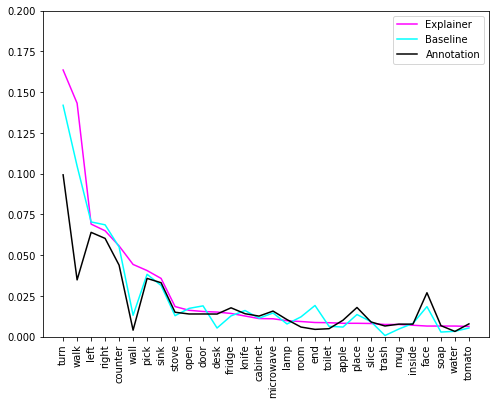

In [357]:
ratios = print_ratio(Main_valid_unseen_word_counts)
chop = 30

plt.figure(figsize=(8, 6))

keys = [w for w,v in ratios][:chop]

Main_dict = make_normalized_dict(Main_valid_unseen_word_counts)
Baseline_dict = make_normalized_dict(Baseline_valid_unseen_word_counts)
Annotation_dict = make_normalized_dict(Annotation_valid_unseen_word_counts)

Main_vals = [Main_dict[k] for k in keys]
Baseline_vals = [Baseline_dict[k] for k in keys]
Annotation_vals = [Annotation_dict[k] for k in keys]

N = len(keys)
ind = np.arange(N)
width = 0.50
plt.ylim([0.0,0.2])

plt.plot(ind, Main_vals, label='Explainer', color='magenta')
plt.plot(ind, Baseline_vals, label='Baseline', color='cyan')
plt.plot(ind, Annotation_vals, label='Annotation', color='k')

plt.legend(loc='upper right')
plt.xticks(ind, keys, rotation=90)
plt.show()

In [339]:
ind

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

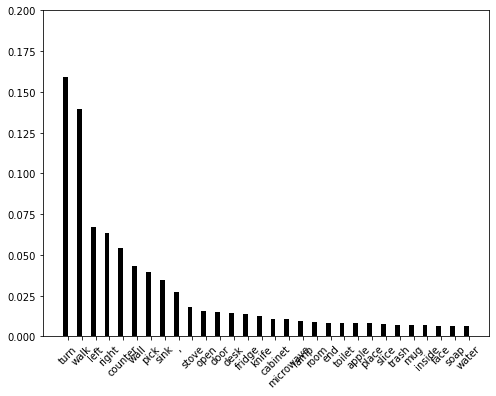

In [308]:
# Explainer
plot_variation(print_ratio(Main_valid_unseen_word_counts))

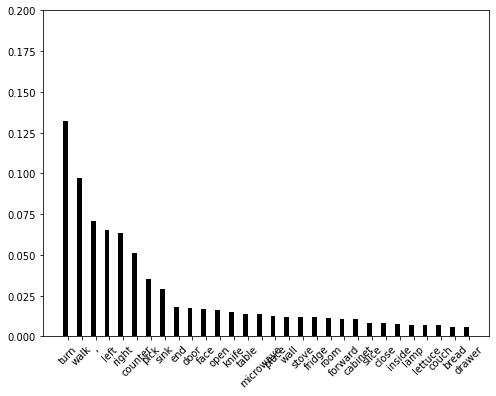

In [309]:
# Baseline
plot_variation(print_ratio(Baseline_valid_unseen_word_counts))

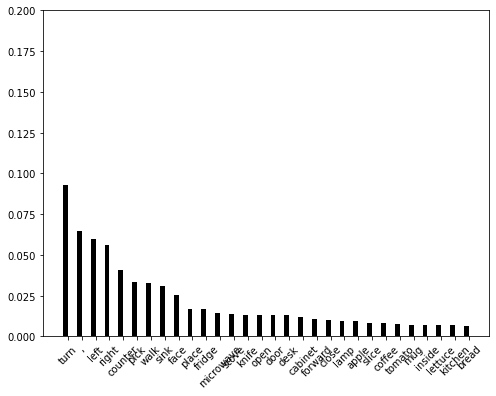

In [310]:
# Crowd-Sourced
plot_variation(print_ratio(Annotation_valid_unseen_word_counts))

### Instr lens Valid Seen

In [169]:
cats = ('GotoLocation', 'SliceObject', 'PickupObject', 'PutObject', 'ToggleObject', 'CleanObject', 'HeatObject', 'CoolObject')

In [179]:
print(sum([sum(d_All_valid_seen[4][subgoal]['Main']) for subgoal in cats])*1.0/sum([len(d_All_valid_seen[4][subgoal]['Main']) for subgoal in cats]))
print(sum([sum(d_All_valid_seen[4][subgoal]['Baseline']) for subgoal in cats])*1.0/sum([len(d_All_valid_seen[4][subgoal]['Baseline']) for subgoal in cats]))
print(sum([sum(d_All_valid_seen[4][subgoal]['Annotation']) for subgoal in cats])*1.0/sum([len(d_All_valid_seen[4][subgoal]['Annotation']) for subgoal in cats]))
print('Slice')
print(sum(d_All_valid_seen[4]['SliceObject']['Main'])*1.0/len(d_All_valid_seen[4]['SliceObject']['Main']))
print(sum(d_All_valid_seen[4]['SliceObject']['Baseline'])*1.0/len(d_All_valid_seen[4]['SliceObject']['Baseline']))
print(sum(d_All_valid_seen[4]['SliceObject']['Annotation'])*1.0/len(d_All_valid_seen[4]['SliceObject']['Annotation']))
print('Put')
print(sum(d_All_valid_seen[4]['PutObject']['Main'])*1.0/len(d_All_valid_seen[4]['PutObject']['Main']))
print(sum(d_All_valid_seen[4]['PutObject']['Baseline'])*1.0/len(d_All_valid_seen[4]['PutObject']['Baseline']))
print(sum(d_All_valid_seen[4]['PutObject']['Annotation'])*1.0/len(d_All_valid_seen[4]['PutObject']['Annotation']))
print('Pickup')
print(sum(d_All_valid_seen[4]['PickupObject']['Main'])*1.0/len(d_All_valid_seen[4]['PickupObject']['Main']))
print(sum(d_All_valid_seen[4]['PickupObject']['Baseline'])*1.0/len(d_All_valid_seen[4]['PickupObject']['Baseline']))
print(sum(d_All_valid_seen[4]['PickupObject']['Annotation'])*1.0/len(d_All_valid_seen[4]['PickupObject']['Annotation']))
print('Goto')
print(sum(d_All_valid_seen[4]['GotoLocation']['Main'])*1.0/len(d_All_valid_seen[4]['GotoLocation']['Main']))
print(sum(d_All_valid_seen[4]['GotoLocation']['Baseline'])*1.0/len(d_All_valid_seen[4]['GotoLocation']['Baseline']))
print(sum(d_All_valid_seen[4]['GotoLocation']['Annotation'])*1.0/len(d_All_valid_seen[4]['GotoLocation']['Annotation']))
print('Clean')
print(sum(d_All_valid_seen[4]['CleanObject']['Main'])*1.0/len(d_All_valid_seen[4]['CleanObject']['Main']))
print(sum(d_All_valid_seen[4]['CleanObject']['Baseline'])*1.0/len(d_All_valid_seen[4]['CleanObject']['Baseline']))
print(sum(d_All_valid_seen[4]['CleanObject']['Annotation'])*1.0/len(d_All_valid_seen[4]['CleanObject']['Annotation']))
print('Heat')
print(sum(d_All_valid_seen[4]['HeatObject']['Main'])*1.0/len(d_All_valid_seen[4]['HeatObject']['Main']))
print(sum(d_All_valid_seen[4]['HeatObject']['Baseline'])*1.0/len(d_All_valid_seen[4]['HeatObject']['Baseline']))
print(sum(d_All_valid_seen[4]['HeatObject']['Annotation'])*1.0/len(d_All_valid_seen[4]['HeatObject']['Annotation']))
print('Cool')
print(sum(d_All_valid_seen[4]['CoolObject']['Main'])*1.0/len(d_All_valid_seen[4]['CoolObject']['Main']))
print(sum(d_All_valid_seen[4]['CoolObject']['Baseline'])*1.0/len(d_All_valid_seen[4]['CoolObject']['Baseline']))
print(sum(d_All_valid_seen[4]['CoolObject']['Annotation'])*1.0/len(d_All_valid_seen[4]['CoolObject']['Annotation']))
print('Toggle')
print(sum(d_All_valid_seen[4]['ToggleObject']['Main'])*1.0/len(d_All_valid_seen[4]['ToggleObject']['Main']))
print(sum(d_All_valid_seen[4]['ToggleObject']['Baseline'])*1.0/len(d_All_valid_seen[4]['ToggleObject']['Baseline']))
print(sum(d_All_valid_seen[4]['ToggleObject']['Annotation'])*1.0/len(d_All_valid_seen[4]['ToggleObject']['Annotation']))


10.072683222289522
10.716535433070867
11.47829598223299
Slice
7.1
7.075
8.2
Put
7.867283950617284
8.95679012345679
10.87037037037037
Pickup
7.823033707865169
8.365168539325843
9.286516853932584
Goto
11.245901639344263
12.147540983606557
12.431693989071038
Clean
16.513513513513512
15.35135135135135
15.036036036036036
Heat
14.969696969696969
13.93939393939394
15.080808080808081
Cool
21.28205128205128
18.153846153846153
18.025641025641026
Toggle
5.482758620689655
5.551724137931035
6.183908045977011


### Instr lens Valid Unseen

In [180]:
print(sum([sum(d_All_valid_unseen[4][subgoal]['Main']) for subgoal in cats])*1.0/sum([len(d_All_valid_unseen[4][subgoal]['Main']) for subgoal in cats]))
print(sum([sum(d_All_valid_unseen[4][subgoal]['Baseline']) for subgoal in cats])*1.0/sum([len(d_All_valid_unseen[4][subgoal]['Baseline']) for subgoal in cats]))
print(sum([sum(d_All_valid_unseen[4][subgoal]['Annotation']) for subgoal in cats])*1.0/sum([len(d_All_valid_unseen[4][subgoal]['Annotation']) for subgoal in cats]))
print('Slice')
print(sum(d_All_valid_unseen[4]['SliceObject']['Main'])*1.0/len(d_All_valid_unseen[4]['SliceObject']['Main']))
print(sum(d_All_valid_unseen[4]['SliceObject']['Baseline'])*1.0/len(d_All_valid_unseen[4]['SliceObject']['Baseline']))
print(sum(d_All_valid_unseen[4]['SliceObject']['Annotation'])*1.0/len(d_All_valid_unseen[4]['SliceObject']['Annotation']))
print('Put')
print(sum(d_All_valid_unseen[4]['PutObject']['Main'])*1.0/len(d_All_valid_unseen[4]['PutObject']['Main']))
print(sum(d_All_valid_unseen[4]['PutObject']['Baseline'])*1.0/len(d_All_valid_unseen[4]['PutObject']['Baseline']))
print(sum(d_All_valid_unseen[4]['PutObject']['Annotation'])*1.0/len(d_All_valid_unseen[4]['PutObject']['Annotation']))
print('Pickup')
print(sum(d_All_valid_unseen[4]['PickupObject']['Main'])*1.0/len(d_All_valid_unseen[4]['PickupObject']['Main']))
print(sum(d_All_valid_unseen[4]['PickupObject']['Baseline'])*1.0/len(d_All_valid_unseen[4]['PickupObject']['Baseline']))
print(sum(d_All_valid_unseen[4]['PickupObject']['Annotation'])*1.0/len(d_All_valid_unseen[4]['PickupObject']['Annotation']))
print('Goto')
print(sum(d_All_valid_unseen[4]['GotoLocation']['Main'])*1.0/len(d_All_valid_unseen[4]['GotoLocation']['Main']))
print(sum(d_All_valid_unseen[4]['GotoLocation']['Baseline'])*1.0/len(d_All_valid_unseen[4]['GotoLocation']['Baseline']))
print(sum(d_All_valid_unseen[4]['GotoLocation']['Annotation'])*1.0/len(d_All_valid_unseen[4]['GotoLocation']['Annotation']))
print('Clean')
print(sum(d_All_valid_unseen[4]['CleanObject']['Main'])*1.0/len(d_All_valid_unseen[4]['CleanObject']['Main']))
print(sum(d_All_valid_unseen[4]['CleanObject']['Baseline'])*1.0/len(d_All_valid_unseen[4]['CleanObject']['Baseline']))
print(sum(d_All_valid_unseen[4]['CleanObject']['Annotation'])*1.0/len(d_All_valid_unseen[4]['CleanObject']['Annotation']))
print('Heat')
print(sum(d_All_valid_unseen[4]['HeatObject']['Main'])*1.0/len(d_All_valid_unseen[4]['HeatObject']['Main']))
print(sum(d_All_valid_unseen[4]['HeatObject']['Baseline'])*1.0/len(d_All_valid_unseen[4]['HeatObject']['Baseline']))
print(sum(d_All_valid_unseen[4]['HeatObject']['Annotation'])*1.0/len(d_All_valid_unseen[4]['HeatObject']['Annotation']))
print('Cool')
print(sum(d_All_valid_unseen[4]['CoolObject']['Main'])*1.0/len(d_All_valid_unseen[4]['CoolObject']['Main']))
print(sum(d_All_valid_unseen[4]['CoolObject']['Baseline'])*1.0/len(d_All_valid_unseen[4]['CoolObject']['Baseline']))
print(sum(d_All_valid_unseen[4]['CoolObject']['Annotation'])*1.0/len(d_All_valid_unseen[4]['CoolObject']['Annotation']))
print('Toggle')
print(sum(d_All_valid_unseen[4]['ToggleObject']['Main'])*1.0/len(d_All_valid_unseen[4]['ToggleObject']['Main']))
print(sum(d_All_valid_unseen[4]['ToggleObject']['Baseline'])*1.0/len(d_All_valid_unseen[4]['ToggleObject']['Baseline']))
print(sum(d_All_valid_unseen[4]['ToggleObject']['Annotation'])*1.0/len(d_All_valid_unseen[4]['ToggleObject']['Annotation']))


11.345454545454546
11.939811912225705
11.894879832810867
Slice
7.03030303030303
6.7272727272727275
7.797979797979798
Put
8.331034482758621
9.33448275862069
10.982758620689655
Pickup
8.17732558139535
8.68313953488372
9.809108527131784
Goto
13.775295663600525
14.015768725361367
12.966272448532633
Clean
20.083333333333332
17.61111111111111
14.824074074074074
Heat
8.857142857142858
16.595238095238095
16.357142857142858
Cool
21.555555555555557
24.694444444444443
20.537037037037038
Toggle
5.30188679245283
4.566037735849057
6.19496855345912


### BLEU/F1Scores

In [25]:
BLEU_train_sanity_mean

{'All': {'Main': 0.4154171079120767,
  'Baseline': 0.574556522506664,
  'Annotation': None},
 'PickupObject': {'Main': 0.5256556565952394,
  'Baseline': 0.6368884505834725,
  'Annotation': None},
 'GotoLocation': {'Main': 0.28353418343044384,
  'Baseline': 0.4637523401106838,
  'Annotation': None},
 'SliceObject': {'Main': 0.6078850943797719,
  'Baseline': 0.7065318186600659,
  'Annotation': None},
 'PutObject': {'Main': 0.5752896379688708,
  'Baseline': 0.7490412327812955,
  'Annotation': None},
 'HeatObject': {'Main': 0.37386064867026114,
  'Baseline': 0.5047169367442084,
  'Annotation': None},
 'ToggleObject': {'Main': 0.6989398122986552,
  'Baseline': 0.8554696212432242,
  'Annotation': None},
 'CoolObject': {'Main': 0.278139591673657,
  'Baseline': 0.40427571118727784,
  'Annotation': None},
 'CleanObject': {'Main': 0.47901538425152473,
  'Baseline': 0.6395940066683866,
  'Annotation': None}}

In [26]:
BLEU_valid_seen_mean

{'All': {'Main': 0.4303076729431442,
  'Baseline': 0.3256177258765944,
  'Annotation': None},
 'PickupObject': {'Main': 0.5393221254427418,
  'Baseline': 0.20785632424495515,
  'Annotation': None},
 'GotoLocation': {'Main': 0.30909600271228976,
  'Baseline': 0.2812002100813576,
  'Annotation': None},
 'SliceObject': {'Main': 0.6890270580858459,
  'Baseline': 0.36595483816009966,
  'Annotation': None},
 'PutObject': {'Main': 0.5505429797810067,
  'Baseline': 0.4918723150590766,
  'Annotation': None},
 'HeatObject': {'Main': 0.4624028172845587,
  'Baseline': 0.375564148142333,
  'Annotation': None},
 'ToggleObject': {'Main': 0.8530572588824399,
  'Baseline': 0.6845441834438333,
  'Annotation': None},
 'CoolObject': {'Main': 0.22849962291455234,
  'Baseline': 0.4219943893980271,
  'Annotation': None},
 'CleanObject': {'Main': 0.49945174801456227,
  'Baseline': 0.48373633502433344,
  'Annotation': None}}

In [27]:
BLEU_valid_unseen_mean

{'All': {'Main': 0.3826716467734774,
  'Baseline': 0.2309654951719045,
  'Annotation': None},
 'PickupObject': {'Main': 0.5169879297668469,
  'Baseline': 0.14508691897060413,
  'Annotation': None},
 'GotoLocation': {'Main': 0.22590935854359662,
  'Baseline': 0.2084784654627459,
  'Annotation': None},
 'SliceObject': {'Main': 0.6277289331035629,
  'Baseline': 0.3370518446082585,
  'Annotation': None},
 'PutObject': {'Main': 0.5204690789596987,
  'Baseline': 0.26224805903405235,
  'Annotation': None},
 'HeatObject': {'Main': 0.4731921159274935,
  'Baseline': 0.4291819726867397,
  'Annotation': None},
 'ToggleObject': {'Main': 0.8622254630250196,
  'Baseline': 0.6965525643720334,
  'Annotation': None},
 'CoolObject': {'Main': 0.2672649385998105,
  'Baseline': 0.20575690285637624,
  'Annotation': None},
 'CleanObject': {'Main': 0.3821045284061087,
  'Baseline': 0.2861979776892265,
  'Annotation': None}}

In [28]:
F1_mean_train_sanity

{'All': {'Main': 0.6366509469495447, 'Baseline': 0.6778091996251658},
 'PickupObject': {'Main': 0.6787179938149478, 'Baseline': 0.6776641897140522},
 'GotoLocation': {'Main': 0.5827965111594556, 'Baseline': 0.6370215937474829},
 'SliceObject': {'Main': 0.6734877734877736, 'Baseline': 0.7149721149721151},
 'PutObject': {'Main': 0.6781032499405998, 'Baseline': 0.7384493964313249},
 'HeatObject': {'Main': 0.7680124223602485, 'Baseline': 0.7858178053830229},
 'ToggleObject': {'Main': 0.798809523809524, 'Baseline': 0.8126984126984128},
 'CoolObject': {'Main': 0.67946001367054, 'Baseline': 0.7056631477684111},
 'CleanObject': {'Main': 0.7230469965764085, 'Baseline': 0.7768051665110489}}

In [29]:
F1_mean_valid_seen

{'All': {'Main': 0.6527551917315699, 'Baseline': 0.5775089011309471},
 'PickupObject': {'Main': 0.683075471137269, 'Baseline': 0.4357715058557757},
 'GotoLocation': {'Main': 0.6041834304129393, 'Baseline': 0.5892161572489445},
 'SliceObject': {'Main': 0.7258134920634921, 'Baseline': 0.5621230158730157},
 'PutObject': {'Main': 0.6935473933930729, 'Baseline': 0.6401642824482332},
 'HeatObject': {'Main': 0.7026214526214527, 'Baseline': 0.7002886002886004},
 'ToggleObject': {'Main': 0.8252873563218392, 'Baseline': 0.7800766283524906},
 'CoolObject': {'Main': 0.6854633021299689, 'Baseline': 0.7148215981549316},
 'CleanObject': {'Main': 0.751667251667252, 'Baseline': 0.7453024453024455}}

In [30]:
F1_mean_valid_unseen

{'All': {'Main': 0.6073774768132126, 'Baseline': 0.44008939974457156},
 'PickupObject': {'Main': 0.6606904454288176, 'Baseline': 0.33927802387104733},
 'GotoLocation': {'Main': 0.5096430483421287, 'Baseline': 0.4234403353982854},
 'SliceObject': {'Main': 0.6886002886002889, 'Baseline': 0.45353535353535357},
 'PutObject': {'Main': 0.7025716110198873, 'Baseline': 0.45384054004743696},
 'HeatObject': {'Main': 0.7673091458805746, 'Baseline': 0.7380385487528348},
 'ToggleObject': {'Main': 0.8197064989517818, 'Baseline': 0.7719077568134171},
 'CoolObject': {'Main': 0.731434049489605, 'Baseline': 0.6774250440917108},
 'CleanObject': {'Main': 0.6994047619047622, 'Baseline': 0.5587889476778365}}

In [31]:
PRECISION_mean_train_sanity

{'All': {'Main': 0.7229060870742768, 'Baseline': 0.741834731048626},
 'PickupObject': {'Main': 0.7178362573099414, 'Baseline': 0.706294244382887},
 'GotoLocation': {'Main': 0.6934926677946986, 'Baseline': 0.72151720248167},
 'SliceObject': {'Main': 0.7327327327327329, 'Baseline': 0.7582582582582585},
 'PutObject': {'Main': 0.7721385542168671, 'Baseline': 0.7984437751004005},
 'HeatObject': {'Main': 0.8719806763285025, 'Baseline': 0.8731884057971014},
 'ToggleObject': {'Main': 0.8571428571428573, 'Baseline': 0.8988095238095238},
 'CoolObject': {'Main': 0.7089181286549711, 'Baseline': 0.7400793650793652},
 'CleanObject': {'Main': 0.7712418300653595, 'Baseline': 0.8032679738562093}}

In [32]:
PRECISION_mean_valid_seen

{'All': {'Main': 0.7314354936402184, 'Baseline': 0.6403963927585974},
 'PickupObject': {'Main': 0.7077871410736578, 'Baseline': 0.45458801498127327},
 'GotoLocation': {'Main': 0.7148661902760267, 'Baseline': 0.677630657138854},
 'SliceObject': {'Main': 0.7527777777777779, 'Baseline': 0.5819444444444444},
 'PutObject': {'Main': 0.7805898491083669, 'Baseline': 0.7016117969821671},
 'HeatObject': {'Main': 0.7373737373737376, 'Baseline': 0.7676767676767677},
 'ToggleObject': {'Main': 0.8505747126436782, 'Baseline': 0.8390804597701149},
 'CoolObject': {'Main': 0.7, 'Baseline': 0.7521367521367522},
 'CleanObject': {'Main': 0.795045045045045, 'Baseline': 0.7702702702702703}}

In [33]:
PRECISION_mean_valid_unseen

{'All': {'Main': 0.6899129223267161, 'Baseline': 0.486391003632384},
 'PickupObject': {'Main': 0.7062338501291984, 'Baseline': 0.3593346253229974},
 'GotoLocation': {'Main': 0.6031537450722734, 'Baseline': 0.47612790188348625},
 'SliceObject': {'Main': 0.7457912457912459, 'Baseline': 0.47474747474747475},
 'PutObject': {'Main': 0.8108620689655168, 'Baseline': 0.5068965517241381},
 'HeatObject': {'Main': 0.9298941798941799, 'Baseline': 0.7842592592592593},
 'ToggleObject': {'Main': 0.8679245283018868, 'Baseline': 0.8962264150943396},
 'CoolObject': {'Main': 0.8060185185185187, 'Baseline': 0.7229938271604941},
 'CleanObject': {'Main': 0.6842592592592592, 'Baseline': 0.5754409171075836}}

In [34]:
RECALL_train_sanity

{'All': {'Main': 0.6122899799773686, 'Baseline': 0.6701880386523918},
 'PickupObject': {'Main': 0.6777931671283468, 'Baseline': 0.6872114496768235},
 'GotoLocation': {'Main': 0.546240230440737, 'Baseline': 0.6208313189912171},
 'SliceObject': {'Main': 0.6582582582582583, 'Baseline': 0.7105105105105106},
 'PutObject': {'Main': 0.6394100210365269, 'Baseline': 0.7217943201376933},
 'HeatObject': {'Main': 0.7413043478260868, 'Baseline': 0.7714975845410629},
 'ToggleObject': {'Main': 0.8124999999999999, 'Baseline': 0.7986111111111109},
 'CoolObject': {'Main': 0.7215434419381788, 'Baseline': 0.7595029239766081},
 'CleanObject': {'Main': 0.7584967320261439, 'Baseline': 0.8114379084967319}}

In [35]:
RECALL_valid_seen

{'All': {'Main': 0.6350807110649641, 'Baseline': 0.5728654110543889},
 'PickupObject': {'Main': 0.6962948100588546, 'Baseline': 0.44361066523987835},
 'GotoLocation': {'Main': 0.5674653215636811, 'Baseline': 0.5762225024520092},
 'SliceObject': {'Main': 0.7456944444444444, 'Baseline': 0.5737500000000001},
 'PutObject': {'Main': 0.6606089555163622, 'Baseline': 0.6263643934940227},
 'HeatObject': {'Main': 0.7072390572390571, 'Baseline': 0.681144781144781},
 'ToggleObject': {'Main': 0.8659003831417624, 'Baseline': 0.8113026819923372},
 'CoolObject': {'Main': 0.744871794871795, 'Baseline': 0.7529914529914531},
 'CleanObject': {'Main': 0.7911411411411413, 'Baseline': 0.801801801801802}}

In [36]:
RECALL_valid_unseen

{'All': {'Main': 0.5879490305352383, 'Baseline': 0.4402514471479985},
 'PickupObject': {'Main': 0.6581314599483201, 'Baseline': 0.3429425064599484},
 'GotoLocation': {'Main': 0.48004505350103194, 'Baseline': 0.4202010721064597},
 'SliceObject': {'Main': 0.6858585858585858, 'Baseline': 0.4661616161616161},
 'PutObject': {'Main': 0.6634674329501908, 'Baseline': 0.4474329501915709},
 'HeatObject': {'Main': 0.6935185185185186, 'Baseline': 0.7517195767195768},
 'ToggleObject': {'Main': 0.8469601677148846, 'Baseline': 0.7505241090146753},
 'CoolObject': {'Main': 0.7415270429159319, 'Baseline': 0.7098838918283362},
 'CleanObject': {'Main': 0.8421296296296297, 'Baseline': 0.622530864197531}}

## Sample Outputs

In [37]:
def compare_sample_outputs(key, subgoal):
    print('Anns')
    for i in range(3):
        print(' '.join(human_anno_valid_unseen[key[:-2]][i][subgoal]))

    print('\nBaseline:\n',B_valid_unseen[key]['p_lang_instr'][str(subgoal)])

    print('\nV2:\n',v2_valid_unseen[key]['p_lang_instr'][str(subgoal)])

## F1

In [38]:
F1_Main_valid_unseen = All_valid_unseen[3]['GotoLocation']['Main']
F1_Base_valid_unseen = All_valid_unseen[3]['GotoLocation']['Baseline']

In [39]:
sorted([(i, M-B) for i,(M,B) in enumerate(zip(F1_Main_valid_unseen, F1_Base_valid_unseen))], key=lambda x: x[1])

[(106, -1.0),
 (206, -1.0),
 (697, -1.0),
 (364, -0.8888888888888888),
 (507, -0.7777777777777777),
 (17, -0.6888888888888888),
 (12, -0.6666666666666666),
 (134, -0.6666666666666666),
 (261, -0.6666666666666666),
 (183, -0.6333333333333333),
 (471, -0.611111111111111),
 (27, -0.5888888888888889),
 (265, -0.5555555555555555),
 (32, -0.5333333333333333),
 (126, -0.5),
 (724, -0.5),
 (715, -0.48888888888888893),
 (500, -0.4666666666666667),
 (611, -0.46666666666666656),
 (689, -0.4507936507936509),
 (668, -0.45000000000000007),
 (496, -0.44444444444444453),
 (18, -0.4444444444444444),
 (294, -0.4444444444444444),
 (296, -0.4444444444444444),
 (276, -0.4222222222222221),
 (319, -0.4126984126984128),
 (585, -0.4000000000000001),
 (186, -0.38888888888888884),
 (504, -0.38888888888888884),
 (740, -0.38888888888888884),
 (573, -0.35555555555555557),
 (50, -0.33333333333333337),
 (313, -0.33333333333333337),
 (323, -0.33333333333333337),
 (23, -0.3333333333333333),
 (273, -0.3333333333333333),

In [40]:
# (80, 0.7777777777777777)
key, subgoal = score_keys_valid_unseen['GotoLocation'][80]
compare_sample_outputs(key, subgoal)

Anns
move across the kitchen to the sink
take the egg and turn right , then right again at the sink
turn right , walk straight , turn right at sink and face sink

Baseline:
 turn right , walk to the counter , turn right to face the counter .

V2:
 turn right and walk to the sink .


In [41]:
# (180, 0.2777777777777777)
key, subgoal = score_keys_valid_unseen['GotoLocation'][180]
compare_sample_outputs(key, subgoal)

Anns
turn around and move forward to the counter that is to the left of the stove
turn to the right and go to the wall , hang a right and go to the counter to the left of the stove where the lettuce is
go to the left of the stove

Baseline:
 turn right , walk to the door , turn right , walk to the stove , turn left to face the stove .

V2:
 turn around and walk to the counter to the right of the stove .


In [42]:
# (695, 1.0)
key, subgoal = score_keys_valid_unseen['GotoLocation'][695]
compare_sample_outputs(key, subgoal)

Anns
turn right and move closer towards the desk
turn right and walk to the wooden desk on the left
turn around right and back to the table

Baseline:
 move to the right side of the dresser where the lamp is .

V2:
 turn right and walk to the desk .


In [43]:
F1_Main_valid_unseen = All_valid_unseen[3]['CoolObject']['Main']
F1_Base_valid_unseen = All_valid_unseen[3]['CoolObject']['Baseline']

In [44]:
sorted([(i, M-B) for i,(M,B) in enumerate(zip(F1_Main_valid_unseen, F1_Base_valid_unseen))], key=lambda x: x[1])

[(30, -0.14444444444444443),
 (33, -0.09682539682539693),
 (0, 0.0),
 (1, 0.0),
 (2, 0.0),
 (3, 0.0),
 (4, 0.0),
 (5, 0.0),
 (7, 0.0),
 (8, 0.0),
 (9, 0.0),
 (14, 0.0),
 (16, 0.0),
 (17, 0.0),
 (20, 0.0),
 (21, 0.0),
 (23, 0.0),
 (24, 0.0),
 (25, 0.0),
 (26, 0.0),
 (28, 0.0),
 (31, 0.0),
 (32, 0.0),
 (11, 0.005555555555555536),
 (15, 0.029365079365079594),
 (19, 0.05158730158730185),
 (34, 0.05158730158730185),
 (10, 0.06349206349206338),
 (6, 0.06349206349206349),
 (35, 0.06507936507936496),
 (29, 0.09908609908609894),
 (18, 0.2),
 (13, 0.3055555555555556),
 (27, 0.31746031746031755),
 (12, 0.37777777777777777),
 (22, 0.5555555555555555)]

In [45]:
# (12, 0.37777777777777777)
key, subgoal = score_keys_valid_unseen['CoolObject'][12]
compare_sample_outputs(key, subgoal)

Anns
open the fridge , put the pan in it , close the fridge , let it cool for a while , open the fridge , pick it up again and close the fridge
place the pan in the fridge , then grab it
open the fridge put in the pan then take it out and close the fridge

Baseline:
 open the fridge and put the plate inside then close the door and then open it again and take the plate out and shut the door .

V2:
 open the fridge and place the pan inside . shut the door and then open the door and pick the pan up again .


In [46]:
# (22, 0.5555555555555555)
key, subgoal = score_keys_valid_unseen['CoolObject'][22]
compare_sample_outputs(key, subgoal)

Anns
place the potato inside the fridge to cool , then take it back out
open the fridge and chill the potato for 5 seconds then take it out
chill the potato in the fridge

Baseline:
 open the fridge and put the egg inside then close the door and then open it again and take the egg out again .

V2:
 chill the potato in the fridge .


In [47]:
F1_Main_valid_unseen = All_valid_unseen[3]['SliceObject']['Main']
F1_Base_valid_unseen = All_valid_unseen[3]['SliceObject']['Baseline']

In [48]:
sorted([(i, M-B) for i,(M,B) in enumerate(zip(F1_Main_valid_unseen, F1_Base_valid_unseen))], key=lambda x: x[1])

[(6, -0.33333333333333326),
 (1, 0.0),
 (2, 0.0),
 (12, 0.0),
 (14, 0.0),
 (16, 0.0),
 (18, 0.0),
 (19, 0.0),
 (21, 0.0),
 (22, 0.0),
 (25, 0.0),
 (26, 0.0),
 (27, 0.0),
 (30, 0.0),
 (9, 0.033333333333333215),
 (11, 0.05555555555555569),
 (4, 0.1904761904761904),
 (24, 0.25555555555555565),
 (15, 0.2888888888888889),
 (29, 0.3),
 (23, 0.30952380952380953),
 (20, 0.3333333333333333),
 (13, 0.35555555555555557),
 (3, 0.37777777777777777),
 (32, 0.38888888888888895),
 (0, 0.4666666666666666),
 (10, 0.5),
 (28, 0.5460317460317462),
 (7, 0.5999999999999999),
 (17, 0.7222222222222222),
 (31, 0.7555555555555555),
 (8, 0.7777777777777777),
 (5, 0.8333333333333334)]

In [49]:
# (5, 0.8333333333333334)
key, subgoal = score_keys_valid_unseen['SliceObject'][5]
compare_sample_outputs(key, subgoal)

Anns
slice the lettuce in the refrigerator
put the knife inside the refrigerator
cut the lettuce in the fridge

Baseline:
 cut the potato in the microwave .

V2:
 open the fridge and cut the lettuce inside the fridge .


In [50]:
# (17, 0.7222222222222222)
key, subgoal = score_keys_valid_unseen['SliceObject'][17]
compare_sample_outputs(key, subgoal)

Anns
cut the apple , in the bin , in to sections
slice the apple in the trash can
slice apple in the trash can

Baseline:
 cut the potato into slices .

V2:
 slice the apple in the trash can .


In [51]:
# (28, 0.5460317460317462)
key, subgoal = score_keys_valid_unseen['SliceObject'][28]
compare_sample_outputs(key, subgoal)

Anns
cut the apple into pieces
cut the apple on the counter with the knife
cut the apple that is to the left of the statue into three pieces with the butter knife

Baseline:
 slice the lettuce on the counter .

V2:
 cut the apple on the counter into three pieces .


In [52]:
# (8, 0.7777777777777777)
key, subgoal = score_keys_valid_unseen['SliceObject'][8]
compare_sample_outputs(key, subgoal)

Anns
slice the apple in the bin
cut the green apple in the bin with the knife
cut the apple in the trash can

Baseline:
 cut the lettuce on the counter into slices .

V2:
 slice the apple in the trash can .


In [53]:
# (31, 0.7555555555555555)
key, subgoal = score_keys_valid_unseen['SliceObject'][31]
compare_sample_outputs(key, subgoal)

Anns
cut the potato in the trash can into slices
cut the potato in the trash can
slice the potato on the right in the trash can

Baseline:
 cut the tomato on the counter into slices .

V2:
 cut the potato in the trash can .


In [54]:
F1_Main_valid_unseen = All_valid_unseen[3]['HeatObject']['Main']
F1_Base_valid_unseen = All_valid_unseen[3]['HeatObject']['Baseline']

In [55]:
sorted([(i, M-B) for i,(M,B) in enumerate(zip(F1_Main_valid_unseen, F1_Base_valid_unseen))], key=lambda x: x[1])

[(9, -0.19999999999999984),
 (39, -0.19999999999999984),
 (32, -0.1333333333333333),
 (26, -0.09999999999999987),
 (27, -0.09999999999999987),
 (5, -0.08888888888888868),
 (6, -0.08571428571428574),
 (7, -0.06666666666666665),
 (19, -0.04603174603174609),
 (0, 0.0),
 (8, 0.0),
 (12, 0.0),
 (13, 0.0),
 (15, 0.0),
 (16, 0.0),
 (17, 0.0),
 (18, 0.0),
 (20, 0.0),
 (21, 0.0),
 (25, 0.0),
 (28, 0.0),
 (35, 0.0),
 (36, 0.0),
 (37, 0.0),
 (38, 0.0),
 (10, 0.022222222222222254),
 (23, 0.022222222222222476),
 (3, 0.0349206349206348),
 (2, 0.04444444444444434),
 (22, 0.0444444444444444),
 (41, 0.0444444444444444),
 (1, 0.05555555555555569),
 (11, 0.06269841269841281),
 (29, 0.06666666666666654),
 (40, 0.06666666666666654),
 (14, 0.1380952380952381),
 (4, 0.15555555555555556),
 (31, 0.1825396825396826),
 (33, 0.2444444444444447),
 (34, 0.3023809523809523),
 (30, 0.3182539682539683),
 (24, 0.4444444444444443)]

In [56]:
# (24, 0.4444444444444443)
key, subgoal = score_keys_valid_unseen['HeatObject'][24]
compare_sample_outputs(key, subgoal)

Anns
place the bread in the microwave , cook it and remove the bread
heat the bread in the microwave and then take it out
place the slice of bread in the microwave , warm it up , then remove it from the microwave

Baseline:
 place the potato slice in the microwave and cook it , then take it out

V2:
 heat the bread in the microwave .


In [57]:
# (34, 0.3023809523809523)
key, subgoal = score_keys_valid_unseen['HeatObject'][34]
compare_sample_outputs(key, subgoal)

Anns
put the potato in the microwave , turn it on to cook , remove the potato
put the potato in the microwave and turn it on and then off and take the potato out and shut the door
cook the potato in the microwave , remove the potato from the microwave

Baseline:
 open the microwave , put the potato inside , close the door , turn on the microwave , after a couple seconds open the microwave back up and take out the potato then close the door .

V2:
 put the potato in the microwave and turn it on . take the potato out of the microwave .


In [58]:
# (1, 0.05555555555555569)
key, subgoal = score_keys_valid_unseen['HeatObject'][1]
compare_sample_outputs(key, subgoal)

Anns
open the microwave , put in the microwave then take it out and close the microwave
put the apple in the microwave and shut the door and then open the door and take the apple out again
put the apple in the microwave , heat it , and take it out

Baseline:
 put the apple in the microwave and shut the door and then open the door and take the apple out and shut the door .

V2:
 heat the apple in the microwave .


In [112]:
F1_Main_valid_unseen = All_valid_unseen[3]['CleanObject']['Main']
F1_Base_valid_unseen = All_valid_unseen[3]['CleanObject']['Baseline']

In [113]:
sorted([(i, M-B) for i,(M,B) in enumerate(zip(F1_Main_valid_unseen, F1_Base_valid_unseen))], key=lambda x: x[1])

[(10, -0.2595238095238095),
 (28, -0.25238095238095215),
 (2, -0.22857142857142865),
 (22, -0.2150793650793651),
 (14, -0.1682539682539682),
 (33, -0.16666666666666674),
 (35, -0.06666666666666654),
 (27, -0.023809523809523725),
 (15, 0.0),
 (21, 0.0),
 (25, 0.0),
 (3, 0.037037037037037035),
 (12, 0.05555555555555569),
 (34, 0.0761904761904762),
 (0, 0.07619047619047625),
 (16, 0.1111111111111111),
 (1, 0.11269841269841252),
 (17, 0.12857142857142845),
 (5, 0.13174603174603172),
 (6, 0.1785714285714285),
 (24, 0.18015873015873007),
 (11, 0.19999999999999984),
 (18, 0.20238095238095222),
 (20, 0.28888888888888875),
 (32, 0.30000000000000016),
 (4, 0.3161375661375661),
 (9, 0.32592592592592595),
 (13, 0.33888888888888885),
 (23, 0.34973544973544957),
 (31, 0.37777777777777777),
 (26, 0.3833333333333333),
 (8, 0.4055555555555555),
 (30, 0.44603174603174606),
 (19, 0.4539682539682541),
 (7, 0.46666666666666684),
 (29, 0.4999999999999999)]

In [118]:
# (30, 0.44603174603174606)
key, subgoal = score_keys_valid_unseen['CleanObject'][30]
compare_sample_outputs(key, subgoal)

Anns
place the lettuce slice in the sink and rinse with water then remove from the sink
wash the lettuce in the sink take the lettuce from the sink
wash the lettuce

Baseline:
 wash the sponge in the sink and then pick it back up and shut off the water .

V2:
 wash the lettuce in the sink .


## BLEU

In [59]:
BLEU_Main_valid_unseen = All_valid_unseen[0]['GotoLocation']['Main']
BLEU_Base_valid_unseen = All_valid_unseen[0]['GotoLocation']['Baseline']

In [60]:
sorted([(i, M-B) for i,(M,B) in enumerate(zip(BLEU_Main_valid_unseen, BLEU_Base_valid_unseen))], key=lambda x: x[1])

[(134, -1.0),
 (163, -1.0),
 (164, -1.0),
 (251, -1.0),
 (436, -1.0),
 (611, -1.0),
 (47, -0.8938651488499076),
 (463, -0.816496580927726),
 (697, -0.7952707287670506),
 (155, -0.7860753021519787),
 (607, -0.7652058832556895),
 (276, -0.710866788975034),
 (295, -0.6703420896351792),
 (407, -0.6613839855692878),
 (55, -0.6606328636027614),
 (523, -0.587728372510532),
 (705, -0.587728372510532),
 (11, -0.5676721706387805),
 (474, -0.5623413251903491),
 (541, -0.5623413251903491),
 (691, -0.5434381355354259),
 (212, -0.5410822690539396),
 (2, -0.5270837136273565),
 (605, -0.5169731539571706),
 (277, -0.5154486831107657),
 (604, -0.5008718428920987),
 (3, -0.488923022434901),
 (588, -0.4832697830906221),
 (649, -0.4799443235030801),
 (167, -0.47987820666906633),
 (198, -0.47818619635155235),
 (169, -0.470515912654231),
 (161, -0.47024301588843226),
 (292, -0.46024953713619404),
 (54, -0.45966135761245924),
 (399, -0.44682021421766044),
 (132, -0.4464617303464354),
 (456, -0.445113087394776

In [61]:
BLEU_Main_valid_unseen = All_valid_unseen[0]['CoolObject']['Main']
BLEU_Base_valid_unseen = All_valid_unseen[0]['CoolObject']['Baseline']

In [62]:
sorted([(i, M-B) for i,(M,B) in enumerate(zip(BLEU_Main_valid_unseen, BLEU_Base_valid_unseen))], key=lambda x: x[1])

[(6, -0.5218570971511476),
 (7, -0.3788774373238062),
 (8, -0.31785613183400635),
 (30, -0.3170543244655532),
 (28, -0.12417640747589681),
 (5, -0.0743839347113841),
 (3, -0.07419400719923913),
 (11, -0.045201647631360975),
 (17, -0.03228667104718208),
 (25, -0.021032059823103022),
 (26, -0.005643292560308044),
 (10, -0.003953413796253746),
 (20, -3.3084515553158765e-78),
 (9, -7.698763952463386e-80),
 (35, 1.8513378965738162e-155),
 (12, 1.792826893755768e-78),
 (1, 2.3928769659721934e-78),
 (31, 2.557615598369626e-78),
 (32, 0.019791900419025038),
 (14, 0.027893233571631287),
 (19, 0.03965197337009402),
 (23, 0.06287719734611041),
 (4, 0.07516487172393499),
 (18, 0.14595716900057673),
 (0, 0.1660839071625199),
 (24, 0.1833570538032509),
 (15, 0.1954262824264842),
 (13, 0.20893625399182006),
 (21, 0.2244217576027018),
 (27, 0.23031963968882546),
 (33, 0.23749876764827982),
 (2, 0.27593241702034227),
 (29, 0.2889608202346523),
 (16, 0.4333207865423752),
 (34, 0.4448364090351645),
 (22,

In [63]:
BLEU_Main_valid_unseen = All_valid_unseen[0]['SliceObject']['Main']
BLEU_Base_valid_unseen = All_valid_unseen[0]['SliceObject']['Baseline']

In [64]:
sorted([(i, M-B) for i,(M,B) in enumerate(zip(BLEU_Main_valid_unseen, BLEU_Base_valid_unseen))], key=lambda x: x[1])

[(6, -1.0),
 (11, -0.24016431434840746),
 (9, -0.15351827510938598),
 (1, 0.0),
 (2, 0.0),
 (12, 0.0),
 (14, 0),
 (16, 0.0),
 (18, 0.0),
 (19, 0.0),
 (21, 0.0),
 (22, 0.0),
 (25, 0.0),
 (26, 0.0),
 (27, 0.0),
 (30, 0.0),
 (13, 4.986094240050794e-78),
 (5, 5.218621439957678e-78),
 (3, 5.30941411456236e-78),
 (24, 0.07857858074038815),
 (4, 0.5727129936037659),
 (10, 0.6223329772884784),
 (20, 0.6803749333171202),
 (29, 0.7165313105737893),
 (28, 0.7476743906106103),
 (15, 0.7725505949016372),
 (23, 0.7952707287670506),
 (0, 1.0),
 (7, 1.0),
 (8, 1.0),
 (17, 1.0),
 (31, 1.0),
 (32, 1.0)]

In [66]:
BLEU_Main_valid_unseen = All_valid_unseen[0]['HeatObject']['Main']
BLEU_Base_valid_unseen = All_valid_unseen[0]['HeatObject']['Baseline']

In [67]:
sorted([(i, M-B) for i,(M,B) in enumerate(zip(BLEU_Main_valid_unseen, BLEU_Base_valid_unseen))], key=lambda x: x[1])

[(1, -0.6227076181783897),
 (23, -0.5035337887555859),
 (0, -0.4857598394971737),
 (40, -0.44996188157333045),
 (21, -0.43513241115910295),
 (7, -0.38676062522190213),
 (31, -0.35285733014385007),
 (39, -0.31733420687191355),
 (10, -0.3048390904376524),
 (17, -0.2850403753157792),
 (12, -0.1873382555613496),
 (16, -0.1750058980162933),
 (5, -0.17404406040011094),
 (33, -0.10891989509241787),
 (14, -1.817992154474331e-78),
 (13, 0.0),
 (25, 0.0),
 (37, 0.0),
 (38, 0.0),
 (36, 1.192097468092001e-78),
 (6, 2.2634109124193657e-78),
 (24, 0.01577652346509545),
 (26, 0.026731847869427283),
 (35, 0.0378748124391709),
 (27, 0.10382818876338418),
 (30, 0.1672844347071943),
 (9, 0.21861648013234242),
 (28, 0.23039356422147134),
 (8, 0.23083943268654128),
 (15, 0.24016431434840746),
 (41, 0.24082019391743603),
 (22, 0.27647050352503977),
 (2, 0.27952792741962756),
 (19, 0.28401854448940134),
 (4, 0.2925637512788283),
 (11, 0.32283217261395114),
 (20, 0.3662456943106682),
 (32, 0.48714390645895156

In [119]:
BLEU_Main_valid_unseen = All_valid_unseen[0]['CleanObject']['Main']
BLEU_Base_valid_unseen = All_valid_unseen[0]['CleanObject']['Baseline']

In [120]:
sorted([(i, M-B) for i,(M,B) in enumerate(zip(BLEU_Main_valid_unseen, BLEU_Base_valid_unseen))], key=lambda x: x[1])

[(33, -0.5303289696957723),
 (27, -0.4535125826143339),
 (17, -0.4398488858884538),
 (14, -0.37638180342761623),
 (3, -0.2951179949113914),
 (16, -0.1981178554870824),
 (1, -0.16576612762082282),
 (2, -0.13904561383729253),
 (22, -0.11979265507107523),
 (10, -0.0642806070248303),
 (18, -0.008281756246017541),
 (15, 0.0),
 (21, 0.0),
 (25, 0.0),
 (20, 0.01652090510819537),
 (0, 0.022678320017337383),
 (32, 0.05748615462299905),
 (9, 0.07312232216334696),
 (26, 0.1353314385900487),
 (11, 0.1448948200770649),
 (28, 0.15772126732343655),
 (23, 0.16497840441262063),
 (34, 0.16562574029564234),
 (5, 0.1797838540213129),
 (4, 0.18496911302350197),
 (12, 0.21701295564080558),
 (31, 0.2291421308389693),
 (6, 0.2437782058765874),
 (7, 0.28592291256793106),
 (13, 0.3656405605147517),
 (24, 0.3695189488472874),
 (35, 0.43335222178469657),
 (29, 0.579508625587),
 (19, 0.616800579706554),
 (8, 0.787745133851862),
 (30, 0.8115760627604967)]

## Plots

In [90]:
def plot_bars(V2_vals, B_vals, title, score_name, cat_names):
    plt.figure(figsize=(8, 6))
    
    N = len(cats)
    ind = np.arange(N)
    width = 0.35
    plt.ylim([0.0,1.0])
    
    # vertical lines
    plt.axvline(x=0.68, color='k', linestyle='dashed', linewidth=0.5 )
    plt.axvline(x=1.68, color='k', linestyle='dashed', linewidth=0.5 )
    plt.axvline(x=5.68, color='k', linestyle='dashed', linewidth=0.5 )
    plt.axvline(x=6.68, color='k', linestyle='dashed', linewidth=0.5 )
    
    # Main data
    plt.bar(ind, V2_vals, width, label='Explainer (with State-Tracking)', color='k')
    for index, value in enumerate(V2_vals): plt.text(index-0.2, value+0.01, str(round(value,2)))
    plt.bar(ind + width, B_vals, width, label='Baseline (without State-Tracking)', color='w', edgecolor='k')
    for index, value in enumerate(B_vals): plt.text(index+0.2, value+0.01, str(round(value,2)))
    
    plt.ylabel(score_name)
    plt.title(title)
    plt.xticks(ind + width / 2, cat_names, rotation=45)
    plt.legend(loc='upper left')
    plt.show()

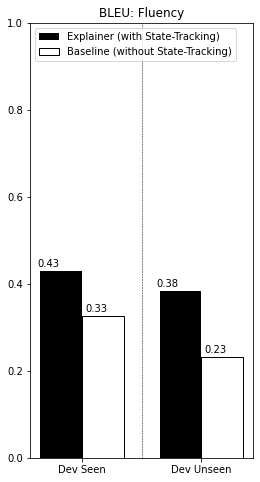

In [368]:
plt.figure(figsize=(4, 8))

ind = np.array((0,1))

width = 0.35
plt.ylim([0.0,1.0])

# vertical lines
plt.axvline(x=0.68, color='k', linestyle='dashed', linewidth=0.5 )

# Main data
V2_vals= BLEU_valid_seen_mean['All']['Main'], BLEU_valid_unseen_mean['All']['Main']
B_vals = BLEU_valid_seen_mean['All']['Baseline'], BLEU_valid_unseen_mean['All']['Baseline']

plt.bar(ind, V2_vals, width, label='Explainer (with State-Tracking)', color='k')
for index, value in enumerate(V2_vals): plt.text(index-0.2, value+0.01, str(round(value,2)))
    
plt.bar(ind + width, B_vals, width, label='Baseline (without State-Tracking)', color='w', edgecolor='k')
for index, value in enumerate(B_vals): plt.text(index+0.2, value+0.01, str(round(value,2)))

    
# plt.ylabel('BLEU score')
plt.title('BLEU: Fluency')
plt.xticks(ind + width / 2, ('Dev Seen', 'Dev Unseen'), rotation=0)
plt.legend(loc='upper left')
plt.show()

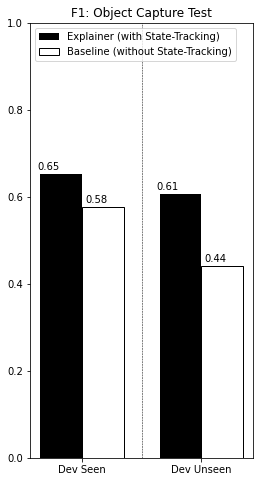

In [369]:
plt.figure(figsize=(4, 8))

ind = np.array((0,1))

width = 0.35
plt.ylim([0.0,1.0])

# vertical lines
plt.axvline(x=0.68, color='k', linestyle='dashed', linewidth=0.5 )

# Main data
V2_vals= F1_mean_valid_seen['All']['Main'], F1_mean_valid_unseen['All']['Main']
B_vals = F1_mean_valid_seen['All']['Baseline'], F1_mean_valid_unseen['All']['Baseline']

plt.bar(ind, V2_vals, width, label='Explainer (with State-Tracking)', color='k')
for index, value in enumerate(V2_vals): plt.text(index-0.2, value+0.01, str(round(value,2)))
    
plt.bar(ind + width, B_vals, width, label='Baseline (without State-Tracking)', color='w', edgecolor='k')
for index, value in enumerate(B_vals): plt.text(index+0.2, value+0.01, str(round(value,2)))

    
# plt.ylabel('F1 score')
plt.title('F1: Object Capture Test')
plt.xticks(ind + width / 2, ('Dev Seen', 'Dev Unseen'), rotation=0)
plt.legend(loc='upper left')
plt.show()

In [70]:
cats = ('All', 'GotoLocation', 'SliceObject', 'PickupObject', 'PutObject', 'ToggleObject', 'CleanObject', 'HeatObject', 'CoolObject')

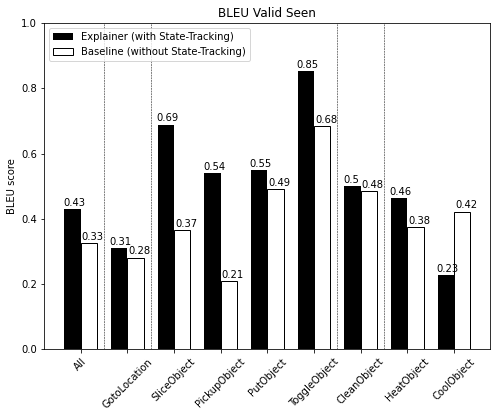

In [330]:
# BLEU Score
plot_bars(V2_vals=[BLEU_valid_seen_mean[cat]['Main'] for cat in cats], 
          B_vals=[BLEU_valid_seen_mean[cat]['Baseline'] for cat in cats], 
          title='BLEU Valid Seen', 
          score_name='BLEU score', 
          cat_names=cats)

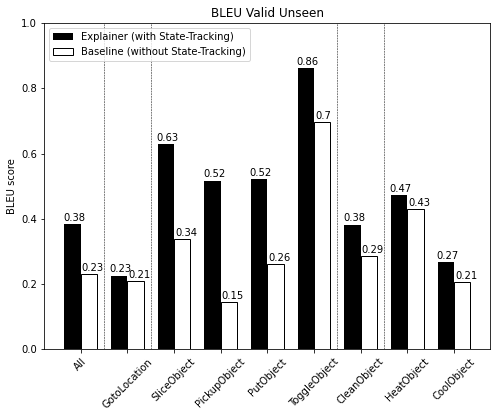

In [331]:
# BLEU Score
plot_bars(V2_vals=[BLEU_valid_unseen_mean[cat]['Main'] for cat in cats], 
          B_vals=[BLEU_valid_unseen_mean[cat]['Baseline'] for cat in cats], 
          title='BLEU Valid Unseen', 
          score_name='BLEU score', 
          cat_names=cats)

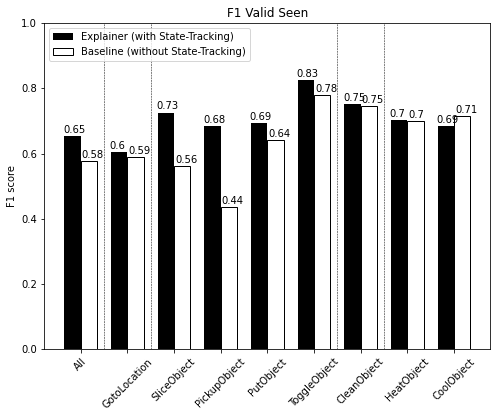

In [332]:
# F1 Score
plot_bars(V2_vals=[F1_mean_valid_seen[cat]['Main'] for cat in cats], 
          B_vals=[F1_mean_valid_seen[cat]['Baseline'] for cat in cats], 
          title='F1 Valid Seen',
          score_name='F1 score', 
          cat_names=cats)

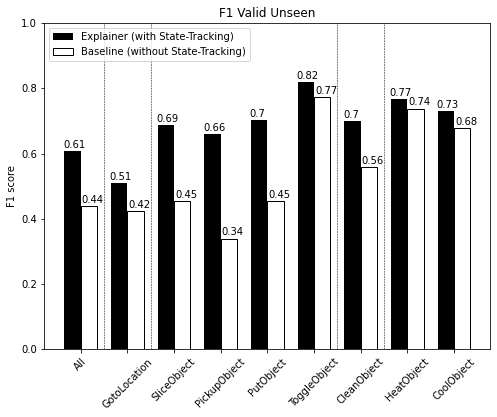

In [333]:
# F1 Score
plot_bars(V2_vals=[F1_mean_valid_unseen[cat]['Main'] for cat in cats], 
          B_vals=[F1_mean_valid_unseen[cat]['Baseline'] for cat in cats], 
          title='F1 Valid Unseen', 
          score_name='F1 score', 
          cat_names=cats)

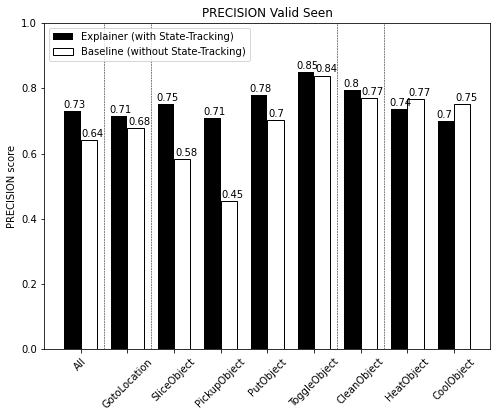

In [334]:
# PRECISION Score
plot_bars(V2_vals=[PRECISION_mean_valid_seen[cat]['Main'] for cat in cats], 
          B_vals=[PRECISION_mean_valid_seen[cat]['Baseline'] for cat in cats], 
          title='PRECISION Valid Seen',  
          score_name='PRECISION score', 
          cat_names=cats)

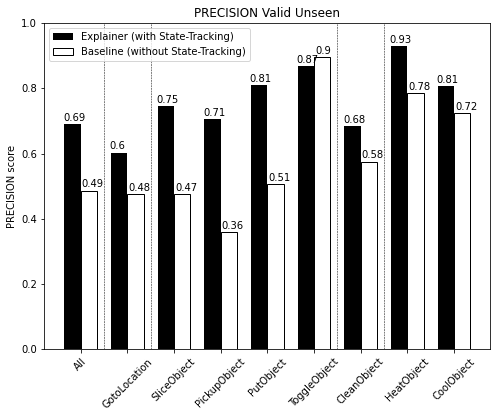

In [335]:
# PRECISION Score
plot_bars(V2_vals=[PRECISION_mean_valid_unseen[cat]['Main'] for cat in cats], 
          B_vals=[PRECISION_mean_valid_unseen[cat]['Baseline'] for cat in cats], 
          title='PRECISION Valid Unseen',  
          score_name='PRECISION score', 
          cat_names=cats)

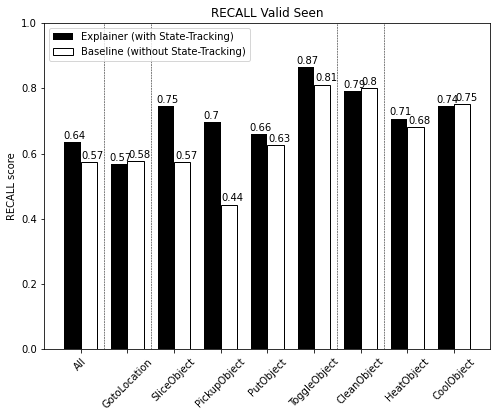

In [72]:
# RECALL Score
plot_bars(V2_vals=[RECALL_valid_seen[cat]['Main'] for cat in cats], 
          B_vals=[RECALL_valid_seen[cat]['Baseline'] for cat in cats], 
          title='RECALL Valid Seen',  
          score_name='RECALL score', 
          cat_names=cats)

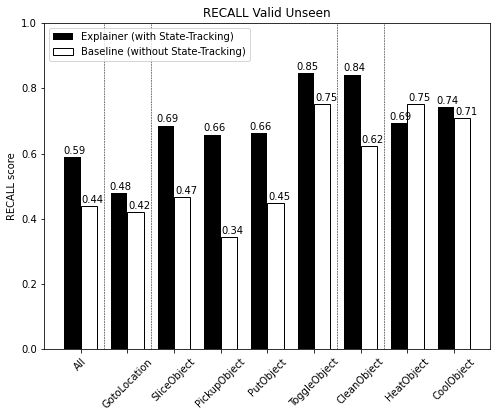

In [71]:
# RECALL Score
plot_bars(V2_vals=[RECALL_valid_unseen[cat]['Main'] for cat in cats], 
          B_vals=[RECALL_valid_unseen[cat]['Baseline'] for cat in cats], 
          title='RECALL Valid Unseen',  
          score_name='RECALL score', 
          cat_names=cats)